In [ ]:
# DRAE Combinación
# 1. Se generan diversos incrustamientos con un diversos métodos RD
# 2. Se utiliza los incrustamientos como referentes para entrednar Encoders
# 3. Se comibinan distintos Encoders para generar un nuevo incrustamiento

In [ ]:
!nvidia-smi

In [ ]:
pip install MKLpy

In [ ]:
pip install umap-learn

In [ ]:
pip install trimap

In [ ]:
pip install slisemap

In [ ]:
######## Para vincular el espacio de trabajo de drive
from google.colab import drive
drive.mount('/content/drive') # Esta no es la ruta del drive, es la ruta interna de colab
%cd /content/drive/MyDrive/TesisCode/DRAE

In [1]:
######## IMPORTACIONES Y UTILS

from modeloAE import Decoder2820, Decoder28, Decoder32, weights_init
import os
from torchvision.utils import save_image
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import math
import random
from KPCA import K_rbf, K_polinomial, kpca, kpcaRBF,  kpcaPoli, pca, pca2
from LLE import klleGpu, K_de_lle, lle
from MDS import kcmdsGpu, K_de_cmds, mds
from LE import kleGpu, K_de_le, kleGpu2, K_de_le2, le, ler
from AEclasico import AEclasico, loadAEclasico
from Data import loadDataTensor
from RD import aplicacionRD, getListaRd
import csv
from cluster import menuCluster
from rdEncoder import rdEnc, loadRdEnc
from time import time
from TSNE import dist, PprobConjuntaNet, QprobConjuntaSne, QprobConjuntaTsne, sneGrad, tsneGrad

# Para integración de UMAP
import networkx as nx
from sklearn.neighbors import NearestNeighbors
from umap.parametric_umap import construct_edge_dataset
#from sklearn.metrics import pairwise_distances

# torch.cuda.set_device(device)
# print(torch.cuda.get_device_name(device=None))

# import pdb   pdb.set_trace()  # para hacer debug

import pytorch_lightning as pl
from torch.utils.data import DataLoader

# **** UTILS **** #

########################################################################
# Procedimiento para graficar el scatter plot del encoder (code)
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
def graficar(mat, bdMet):
    matx = mat[:, 0]
    maty = mat[:, 1]
    ets = mat[:, 2]
    numEt = len(clases)
    plt.scatter(matx, maty, c=ets, label=clases,
                cmap=plt.cm.get_cmap('jet', numEt))

    if bdMet:  # para saber si muestra las etiquetas en el gráfico o no
        for label, x, y in zip(ets, matx, maty):
            plt.annotate(
                label,
                xy=(x, y), xytext=(-20, 20),
                textcoords='offset points', ha='right', va='bottom',
                bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    plt.show()

########################################################################
# Procedimiento para graficar el scatter plot del encoder (code) con etiquetas diferentes al conjunto original
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
def graficarConEtClus(mat, etCluster, bdMet):
    matx = mat[:, 0]
    maty = mat[:, 1]
    numEt = len(clases)
    plt.scatter(matx, maty, c=etCluster, marker='o',
                label=clases, cmap=plt.cm.get_cmap('jet', numEt))

    if bdMet:  # para saber si muestra las etiquetas en el gráfico o no
        for label, x, y in zip(etCluster, matx, maty):
            plt.annotate(
                label,
                xy=(x, y), xytext=(-20, 20),
                textcoords='offset points', ha='right', va='bottom',
                bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

########################################################################
# Grafica la rd de un modelo cargado
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
def graficarRdModel(pos):
    metodo = listaModelos[pos]
    x = metodo.rd[:, 0]
    y = metodo.rd[:, 1]
    numEt = len(clases)
    plt.scatter(x, y, c=labelsIn, label=clases,
                cmap=plt.cm.get_cmap('jet', numEt))
    plt.show()
    
def graficarRdMetodos(pos, listaMetodos):
    metodo = listaMetodos[pos]
    x = metodo.rd[:, 0]
    y = metodo.rd[:, 1] 
    numEt = len(clases)
    plt.scatter(x, y, c=labelsIn, label=clases,
                cmap=plt.cm.get_cmap('jet', numEt))
    plt.show()

########################################################################
# Genera una matriz de graficas que contiene la RD de un método, la clusterización y la intersección
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
def matGraficos(metodos, interseccion, centroides):

    nmets = len(metodos)
    fig = plt.figure(figsize=(20, 20))
    print("nmets", nmets)
    cn = 1
    for met in metodos:
        subplot(nmets, 3, cn)
        graficar(met.rd, False)
        title(met.nombre+' Rd')
        cn = cn+1

        subplot(nmets, 3, cn)
        graficarConEtClus(met.rd, met.cluster, False)
        title('Clus')
        cn = cn+1

        subplot(nmets, 3, cn)
        graficar(interseccion, False)
        scatter(centroides[:, 0], centroides[:, 1],
                c="black",  marker='*', s=300)
        title('Int')
        cn = cn+1

########################################################################
# Función para guardar los datos de entrada Xin
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
def guardarXL(nombreDB):
    print("Guardando Xin y el labelsIn...")
    with open('./RNXmat/Xin'+nombreDB+'.dat', 'w', newline='', encoding='utf-8') as csvfile2:
        writer = csv.writer(csvfile2)
        writer.writerows(Xin)

    output_array = np.array(labelsIn)
    np.savetxt("./RNXmat/labelsIn"+nombreDB +
               ".csv", output_array, delimiter=",")

########################################################################
# Función para guardar archivo para RNX de la combinacion
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
def guardarRdRnx(nombreRd, datos):
    with open('./RNXmat/' + nombreRd + '.dat', 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(datos)

########################################################################
# Función para guardar archivo RD de métodos originales, utilizada para hacer ensamble de métodos rd
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
def guardarRDensamble(nombreRd, datos):
    ruta2d = "./model/2d_RD_" + nombreRd + ".csv"
    with open(ruta2d, 'w', newline='', encoding='utf-8') as csvfile2rd:
        writer = csv.writer(csvfile2rd)
        writer.writerows(datos)


########################################################################
# procedimiento para guardar imagenes del out (decoder)
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
if not os.path.exists('./decodeImgs'):
    os.mkdir('./decodeImgs')


def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)

    if rowImg == 28:
        x = x.view(x.size(0), 1, 28, 28)
    elif rowImg == 32:
        x = x.view(x.size(0), 1, 32, 32)
    elif rowImg == 20:
        x = x.view(x.size(0), 1, 28, 20)

    return x

# guarda las imagenes del out (decode)


def guardarImagenesDec(nomImgDec, decodes):
    # decodes=torch.from_numpy(decodes).to(device)
    for i in range(len(decodes)):
        pic = to_img(decodes[i])
        save_image(pic, './decodeImgs/Ensamblaje' +
                   nomImgDec+'_{}.png'.format(i))

########################################################################
# Clusters
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
def clusteres(rdEnc):
    Xclu = rdEnc[:, :2]
    menuCluster(Xclu, rdEnc[:, 2], len(clases))


########################################################################
# Genera el decoder
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
def getDecoder(rdEnc):

    if rowImg == 28:  # para imagenes como mnist que son de 28*28
        decoder = Decoder28(codesize=2).apply(weights_init)
        decoder.to(device)
    elif rowImg == 32:  # para imagenes como Coil20 o CIFAR que son de 32*32 con diferente numero de canales
        decoder = Decoder32(codesize=2, nChanelsIn=nCh).apply(weights_init)
        decoder.to(device)
    elif rowImg == 20:  # para imagenes como face que son de 28*20
        decoder = Decoder2820(codesize=2).apply(weights_init)
        decoder.to(device)

    # criterion = nn.SmoothL1Loss().to(device)
    criterion = nn.MSELoss()  # error

    learning_rate = 0.001  # 0.0001 0.001 #1e-3
    optimizerDec = optim.Adam(decoder.parameters(
    ), lr=learning_rate, weight_decay=1e-5)  # 0.01  1e-5

    # Train the network (DECODER)
    from torch.autograd import Variable
    from tqdm import tqdm  # barra de tiempo

    if rowImg == 28:
        decodes = np.random.rand(0, 1, 28, 28)
    elif rowImg == 20:
        decodes = np.random.rand(0, 1, 28, 20)
    elif rowImg == 32:
        decodes = np.random.rand(0, 1, 32, 32)

    print('Start Training Decode')
    numepochs = 1000  # 100
    for epoch in tqdm(range(numepochs)):

        # recorre las imagenes por minilotes. El tamaño del minilote se estableció en 64 (batch_size=64) por lo que el trainloader carga minilotes de 64 imagenes (inputs torch.Size([64, 1, 28, 28] es decir [tamaño minilote, 1, 28, 28] en otras palabras: 64 imagens monocromaticas (1 canal rgb) de 28x28 pixeles))
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # wrap them in Variable
            # la función Variable (obsoleta creo) creo que es similar a poner requires_grad=True
            inputs, labels = Variable(inputs), Variable(labels)

            # zero the parameter gradients
            optimizerDec.zero_grad()

            # ===============Adapta el tamaño del encodeRd al minilote (para poder comparar el code con el subcojunto mini de RD)
            encodeRdMini = rdEnc[list(trainloader._index_sampler)[i]]
            encodeRdMini = torch.from_numpy(encodeRdMini).to(device)
            encodeRdMini = encodeRdMini.float()
            # ==========================================================

            # *** forward + backward + optimize
            out = decoder(encodeRdMini)  # forward

            if epoch == numepochs-1:  # solo guardo en la ultima epoca, donde los parametros ya han sido optimizados
                decodes = np.concatenate((decodes, out.cpu().data), axis=0)

            loss = criterion(inputs, out)  # backward
            loss.backward()  # backward

            optimizerDec.step()  # optimize

        if epoch % int(0.1*numepochs) == 0:
            print(f'epoch {epoch} \t Loss: {loss.item():.4g}')

    print('Finished Training Decode')

    torch.save(decoder.state_dict(), "./model/DecodeCombinacion.model")

    return decodes

########################################################################
# Carga un archivo
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
def loadFile(nombreFile):
    matL = np.transpose(np.loadtxt("./RNXmat/"+nombreFile +
                        ".dat", delimiter=',', unpack=True))
    return matL

########################################################################
# Carga un archivo Matlab
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
def loadFileMatlab(nombreFile, vep):
    import scipy.io
    mat = scipy.io.loadmat("./RNXmat/"+nombreFile+".mat")
    # vep es el nombre de la variable en el espacio de trabajo en matlab
    Xmat = mat[vep]
    Xmat = np.column_stack((Xmat, labelsIn))
    return Xmat

########################################################################
# Clase Métodos rd
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
class MetodoRd:
    nombre = ""
    tipo = ""  # clasico o kernel
    rd = object
    K = object
    cluster = np.random.rand(0)  # np.array([[0]])
    subsetsCluster = {}
    etTamanoSubsets = []
    rnx = 0
    metricasCluster = 0
    indexOriginales = []

########################################################################
# Clase Modelos de Métodos rd
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
class ModelMetodoRd:
    model = object
    rd = object

########################################################################
# Genera la normalizaciòn inter e intra columnas de la matriz de distancias (Dr. Miguel Antel)
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
def normInterIntra(Dx):

    nfls, ncls = Dx.shape
    em = (nfls-1)*(ncls-1)  # Error maximo

    # raíz cuadrada de la suma de los cuadrados de los elementos del vector columna
    den = torch.linalg.norm(Dx, dim=1, ord=2)
    # den = Dx.pow(2).sum(dim=1).sqrt() # Equivalente
    # den = Dx.norm(dim=1, p=2) # Equivalente
    # print("den", den)

    nIntra = Dx/den   # se divide cada elemento del vector columna por la raíz cuadrada anterior
    nIntra2 = nIntra/em
    # print("nIntra", nIntra) # nIntra en la normalización intra-columna

    # PARA NORMALIZACION INTERCOLUMNA

    nIntra.fill_diagonal_(0)  # Se elimina la diagonal
    # print("nIntra", nIntra)

    # Se convierte la matriz en un vector con los valores del triangulo superior (sin la diagonal).
    Tu = torch.triu(nIntra).flatten()
    # print("Tu", Tu) # Aún cuando el vector real es N(N-1)/2, no se eliminan los valores 0 para no perder la referencia con la matriz original y por consiguiente la referencia en el grafo de derivación

    den2 = torch.linalg.norm(Tu, dim=0, ord=2)
    # print("den2", den2)

    nInter = Tu/den2   # se divide cada elemento del vector columna por la raíz cuadrada anterior
    # print("nInter", nInter) # nInter en la normalización inter-columnas, vector resultante que codifica la matriz de distancia inicial.

    # dotNorm = 1 - torch.dot(nInter, nInter)
    # print("1 - dotNorm", dotNorm)

    return nIntra2, nInter

########################################################################
# Kernel
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
def K_polinomial(X, p, c, s):

    X = X.float()

    # X = X.cpu().data

    # standardize the columns of the data
    # X = StandardScaler().fit_transform(X)<
    # X = torch.from_numpy(X).cuda()

    # x*x'
    # K = torch.mm(X,torch.t(X)) # covarianza
    K = torch.pow((s*X+c), p)
    # centrado del kernel
    n, p = K.shape
    K = centrar(K, n)
    # print("Kernel polinomial: \n",K)
    return K


def centrar(K, N):
    K = 0.5*(K + torch.t(K))
    # suma los elementos de una columna y cada uno lo divide entre N
    kS = torch.sum(K, 0)/N
    kSm = kS.repeat(N, 1)  # construye una matriz repitiendo n veces una linea
    # es como el bsxfun(@plus, kS, kS') en Matlab
    K = K - (kSm+torch.t(kSm)) + (torch.sum(kS)/N)
    return K

########################################################################
# Device
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Verifica si CUDA (GPU) está disponible
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Se ha encontrado una GPU CUDA. Se utilizará CUDA.")
    torch.cuda.get_device_name(0)
else:
    device = torch.device("cpu")
    print("No se ha encontrado una GPU CUDA. Se utilizará la CPU.")

    
########################################################################
#   **** UMAP **** 
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

##############++++++++++++++++++++++++++++++++ Parte 1: Construir el grafo de vecindarios HD

#__________________________ Obtención del grafo, Forma 1 en pytorch

from sklearn.utils import check_random_state
from umap.umap_ import fuzzy_simplicial_set
from torch.utils.data import Dataset, DataLoader

def get_umap_graph(X, n_neighbors=10, metric="cosine", random_state=None):
    random_state = check_random_state(None) if random_state == None else random_state
    # number of trees in random projection forest
    n_trees = 5 + int(round((X.shape[0]) ** 0.5 / 20.0))
    # max number of nearest neighbor iters to perform
    n_iters = max(5, int(round(np.log2(X.shape[0]))))
    # distance metric

    # get nearest neighbors
    nnd = NNDescent(
        X.reshape((len(X), np.product(np.shape(X)[1:]))),
        n_neighbors=n_neighbors,
        metric=metric,
        n_trees=n_trees,
        n_iters=n_iters,
        max_candidates=60,
        verbose=True
    )
    # get indices and distances
    knn_indices, knn_dists = nnd.neighbor_graph

    # get indices and distances
    knn_indices, knn_dists = nnd.neighbor_graph
    # build fuzzy_simplicial_set
    umap_graph, sigmas, rhos = fuzzy_simplicial_set(
        X = X,
        n_neighbors = n_neighbors,
        metric = metric,
        random_state = random_state,
        knn_indices= knn_indices,
        knn_dists = knn_dists,
    )
    return umap_graph

def get_graph_elements(graph_, n_epochs):

    graph = graph_.tocoo()
    # eliminate duplicate entries by summing them together
    graph.sum_duplicates()
    # number of vertices in dataset
    n_vertices = graph.shape[1]
    # get the number of epochs based on the size of the dataset
    if n_epochs is None:
        # For smaller datasets we can use more epochs
        if graph.shape[0] <= 10000:
            n_epochs = 500
        else:
            n_epochs = 200
    # remove elements with very low probability
    graph.data[graph.data < (graph.data.max() / float(n_epochs))] = 0.0
    graph.eliminate_zeros()
    # get epochs per sample based upon edge probability
    epochs_per_sample = n_epochs * graph.data

    head = graph.row
    tail = graph.col
    weight = graph.data

    return graph, epochs_per_sample, head, tail, weight, n_vertices

class UMAPDataset(Dataset):
     def __init__(self, data, graph_, n_epochs=200):
         graph, epochs_per_sample, head, tail, weight, n_vertices = get_graph_elements(graph_, n_epochs)
        
         self.edges_to_exp, self.edges_from_exp = (np.repeat(head, epochs_per_sample.astype("int")), np.repeat(tail, epochs_per_sample.astype("int")),)
         shuffle_mask = np.random.permutation(np.arange(len(self.edges_to_exp)))
         self.edges_to_exp = self.edges_to_exp[shuffle_mask].astype(np.int64)
         self.edges_from_exp = self.edges_from_exp[shuffle_mask].astype(np.int64)
         self.data = torch.Tensor(data)
        
     def __len__(self):
         return int(self.data.shape[0])
    
     def __getitem__(self, index):
         edges_to_exp = self.data[self.edges_to_exp[index]]
         edges_from_exp = self.data[self.edges_from_exp[index]]
         return (edges_to_exp, edges_from_exp)

class Datamodule(pl.LightningDataModule):
    def __init__(
        self,
        dataset,
        batch_size,        
        num_workers,
    ):
        super().__init__()
        self.dataset = dataset
        self.batch_size = batch_size
        self.num_workers = num_workers

    def train_dataloader(self) -> DataLoader:
        return DataLoader(
            dataset=self.dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
        )
        
# class MatchDataset(Dataset):
#     def __init__(self, data, embeddings):
#         self.embeddings = torch.Tensor(embeddings)
#         self.data = data
#     def __len__(self):
#         return int(self.data.shape[0])
#     def __getitem__(self, index):
#         return self.data[index], self.embeddings[index]


#________________________ 2da Forma de obtener el Grafo UMAP UMAP

from pynndescent import NNDescent
import numpy as np
import tensorflow as tf
def getGrafoHD(Xin, n_neighbors):

    # number of trees in random projection forest
    n_trees = 5 + int(round((Xin.shape[0]) ** 0.5 / 20.0))
    # max number of nearest neighbor iters to perform
    n_iters = max(5, int(round(np.log2(Xin.shape[0]))))
    # distance metric
    metric="euclidean"
    # number of neighbors for computing k-neighbor graph
    #n_neighbors = 10

    # get nearest neighbors
    nnd = NNDescent( Xin.reshape((len(Xin), np.product(np.shape(Xin)[1:]))), n_neighbors=n_neighbors, metric=metric, n_trees=n_trees, n_iters=n_iters, max_candidates=60, verbose=True)
    # get indices and distances
    knn_indices, knn_dists = nnd.neighbor_graph

    # Construir complejo simplicial difuso
    # La función fuzzy_simplicial_set toma el grafo del vecino más próximo y computa un grafo de las probabilidades de que exista una arista entre puntos.
    # Las probabilidades locales, unidireccionales (P UMAP i|j), se calculan entre un punto y sus vecinos para determinar la probabilidad de que exista un borde (o simplex), basándose en la suposición de que 
    # los datos se distribuyen uniformemente a través de un múltiple en un espacio de datos deformado. 
    # Bajo este supuesto, se establece una noción local de distancia mediante la distancia al késimo vecino más cercano y la probabilidad local se escala por esa noción local de distancia.
    # p UMAPj∣i = exp(−(d(xi,xj)−ρi)/σi)
    # Donde ρi es un parámetro de conectividad local ajustado a la distancia de xi a su vecino más cercano, y σi es un parámetro de conectividad local ajustado a la distancia local alrededor de xi a sus 
    # k vecinos más cercanos (donde k es un hiperparámetro). 
    # En el paquete UMAP, estos parámetros se calculan usando smooth_knn_dist.
    # Después de calcular las probabilidades de borde unidireccional para cada punto de datos, calculamos una probabilidad global como la probabilidad de que ocurra cualquiera de las dos probabilidades 
    # locales unidireccionales:
    # pij=(pj∣i+pi∣j)−pj∣ipi∣j
    
    #///video
    # p UMAPj∣i = exp(−(d(xi,xj)−ρi)/σi)  ecuación para las puntuaciones de similitud:  se eleva la distancia bruta negativa menos la distancia al vecino mas cercano dividido por sigma
    # pij=(pj∣i+pi∣j)−pj∣ipi∣j  o  SymetricalScore=(S1+S2)-S1S2   Hace que las puntuaciones sean simetricas
    
    from sklearn.utils import check_random_state
    from umap.umap_ import fuzzy_simplicial_set
    random_state = check_random_state(None)
    # build fuzzy_simplicial_set
    umap_graph, sigmas, rhos = fuzzy_simplicial_set(X=Xin, n_neighbors=n_neighbors, metric=metric, random_state=random_state, knn_indices=knn_indices, knn_dists=knn_dists,)
    return umap_graph, sigmas, rhos



##############++++++++++++++++++++++++++++++++ Para Ld

# convert probabilities to distances
# Low-d Scores = 1 / 1 + ad**(2b) calcula puntuaciones de similitud en baja dimensión, donde d es la distancia en baja, y a y b estan ligados con la agrupacion y dispersión
# de forma predeterminada alfa es igual a 1.577 y beta es igual a  0.8951. Si alfa y beta son igual a 1, las puntuaciones serían igual a las de T-SNE

def convert_distance_to_probability_forma1(distances, a=1.0, b=1.0):
     return 1.0 / (1.0 + a * distances ** (2 * b))

def convert_distance_to_probability(distances, a=1.0, b=1.0):
    return -torch.log1p(a * distances ** (2 * b))

############## Para comparación
# Por último, calculamos el coste de la entropía cruzada que UMAP optimizará utilizando el descenso gradiente:
#  Cumap = sumatoria pij log(pij/qij) + (1-pij) log (1-pij / 1-qij)
# Otra forma de ver es  cost = log(1/vecinos) + log(1/1 - NO vecinos)

def compute_cross_entropy_forma1(probabilities_graph, probabilities_distance, EPS=1e-4, repulsion_strength=1.0):
    # cross entropy
    attraction_term = -probabilities_graph * torch.log(torch.clamp(probabilities_distance, EPS, 1.0))
    repellant_term = (-(1.0 - probabilities_graph) * torch.log(torch.clamp(1.0 - probabilities_distance, EPS, 1.0))* repulsion_strength)

    # balance the expected losses between atrraction and repel
    CE = attraction_term + repellant_term
    return attraction_term, repellant_term, CE

############## cross entropy Umap como función de costo
import torch.nn as nn
class compute_cross_entropy2(nn.Module):
    def __init__(self):
        super(compute_cross_entropy2, self).__init__()

    def forward(self, probabilities_graph, probabilities_distance, EPS=1e-4, repulsion_strength=1.0):
        # cross entropy
        attraction_term = -probabilities_graph * torch.log(torch.clamp(probabilities_distance, EPS, 1.0))
        repellant_term = (-(1.0 - probabilities_graph) * torch.log(torch.clamp(1.0 - probabilities_distance, EPS, 1.0)) * repulsion_strength)

        # balance the expected losses between atrraction and repel
        CE = attraction_term + repellant_term
        CE = CE.mean() #o torch.sum()
        print("CEEEEEEEEEEEEEEEEEEEEEE", CE)
        return CE # attraction_term, repellant_term, 
    
def compute_cross_entropy(probabilities_graph, probabilities_distance, EPS=1e-4, repulsion_strength=1.0):
    # cross entropy
    attraction_term = -probabilities_graph * torch.nn.functional.logsigmoid(probabilities_distance)
    repellant_term = (-(1.0 - probabilities_graph) * (torch.nn.functional.logsigmoid(probabilities_distance)-probabilities_distance) * repulsion_strength)

    # balance the expected losses between atrraction and repel
    CE = attraction_term + repellant_term
    return attraction_term, repellant_term, CE


############## Umap Loss
def umap_loss(embedding_to, embedding_from, _a, _b, batch_size, negative_sample_rate=5):
    # get negative samples by randomly shuffling the batch
    embedding_neg_to = embedding_to.repeat(negative_sample_rate, 1)
    repeat_neg = embedding_from.repeat(negative_sample_rate, 1)
    embedding_neg_from = repeat_neg[torch.randperm(repeat_neg.shape[0])]
    distance_embedding = torch.cat((
        (embedding_to - embedding_from).norm(dim=1),
        (embedding_neg_to - embedding_neg_from).norm(dim=1)
    ), dim=0)

    # convert probabilities to distances
    probabilities_distance = convert_distance_to_probability(
        distance_embedding, _a, _b
    )
    # set true probabilities based on negative sampling
    probabilities_graph = torch.cat(
        (torch.ones(batch_size), torch.zeros(batch_size * negative_sample_rate)), dim=0,
    )

    # compute cross entropy
    (attraction_loss, repellant_loss, ce_loss) = compute_cross_entropy(
        probabilities_graph.to(device),
        probabilities_distance.to(device),
    )
    loss = torch.mean(ce_loss)
    return loss

class umap_loss_Function(nn.Module):
    def __init__(self):
        super(umap_loss_Function, self).__init__()

    def forward(self, embedding_to, embedding_from, _a, _b, batch_size, negative_sample_rate=5):
        # get negative samples by randomly shuffling the batch
        embedding_neg_to = embedding_to.repeat(negative_sample_rate, 1)
        repeat_neg = embedding_from.repeat(negative_sample_rate, 1)
        embedding_neg_from = repeat_neg[torch.randperm(repeat_neg.shape[0])]
        distance_embedding = torch.cat(((embedding_to - embedding_from).norm(dim=1), (embedding_neg_to - embedding_neg_from).norm(dim=1)), dim=0)

        # convert probabilities to distances
        probabilities_distance = convert_distance_to_probability(distance_embedding, _a, _b)
        # set true probabilities based on negative sampling
        probabilities_graph = torch.cat((torch.ones(batch_size), torch.zeros(batch_size * negative_sample_rate)), dim=0,)

        # compute cross entropy
        (attraction_loss, repellant_loss, ce_loss) = compute_cross_entropy(probabilities_graph.to(device), probabilities_distance.to(device),)
        
        loss = torch.mean(ce_loss)
        return loss

No se ha encontrado una GPU CUDA. Se utilizará la CPU.


DataSets
	1 - Generación de datos de la fuente
	2 - Carga de datos desde archivo generado
	Z - Salir
Cargando Trainloader, Xin y LabelsIn asociados al modelo...
MENU DE DATOS TENSORIALES
	1 - FashionMNIST
	2 - MNIST
	3 - CIFAR
	4 - Coil20
	5 - Faces
	6 - Tufts
	7 - naturalImages
	8 - Signs
	9 - FER
	10 - Chess
	11 - Lego
	12 - Brain
	13 - Chest_xray
	14 - SenosGT
	15 - Senos
	16 - Pulmon
	17 - PulmonCNPT
	18 - Glaucoma
	19 - Brain17
	20 - Brain44
	21 - Osteoartritis
	22 - Brain300x300
	24 - USPS
	25 - Imagenette
	26 - Intel
	27 - Vegetable
	28 - MedicalMnist
	29 - IndiansignLanguage
	23 - Salir

Has selecionado el data set Indian signLanguage
images  torch.Size([10000, 1, 32, 32])
labels  torch.Size([10000])


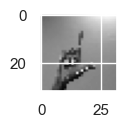

tamaño del cojunto de datos o lote 10000
tamaño del mini lote 10000
numero de minilotes  1
X  torch.Size([10000, 1, 32, 32])
y torch.Size([10000])


In [2]:

# 1. DATOS  (para entrenar)
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

# lego 6379, coil 1440, Fmnist = 10000, USPS = 7291, Imagennet = 9469, Intel = 14034, Vegetable = 21000, medicalMnist = 58954 (10000), animals = 28000, signLenguage = 10000

clases = ""
# El ultimo valor es el tamaño del minilote, aqui las etiquetas las estoy tomando como clases
trainloader, clases, Xin, labelsIn, Xint, dimImg, rowImg, nCh, nombreDB = loadDataTensor('./RNXmat/Xin', "./RNXmat/labelsIn", 10000, device)
Xint = torch.from_numpy(Xin).float().to(device)
nc = len(clases)
fl = len(Xin)
cl = 2  # dimensiones1

opcData = "1"  # "1" para Tensores o "2" para matrices

In [ ]:
# Generación de incrustamiento  <<<<<<<<---------------------------|||
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

print("MENU DE COMBINACION RD")
print("\tA - Aplicación de métodos RD")
print("\tB - Cargar incrustamientos RD")
print("\tC - Generar modelos Encoder")
print("\tD - Cargar modelos Encoder")
print("\tZ - Salir")
opcionEnc = input("Seleccione la opción: >> ")

listaMetodos = list()
listaModelos = list()

if opcionEnc == "A" or opcionEnc == "a":

    d = int(input("Suministre la dimensión del incrustamiento:  >> "))
    cn = 0
    opcionRepiteRd = "S"
    while opcionRepiteRd == "S" or opcionRepiteRd == "s":
        cn += 1
        print("Aplicación de métodos RD: ", cn)
        # labelsIn solo para apredizaje supervisado LDA, los demás métodos no requieren
        encodeRd, kernel, metrd = aplicacionRD(
            Xint, labelsIn, clases, d, device)
        encodeRd = encodeRd.cpu().detach().numpy()
        encodeRd = np.column_stack((encodeRd, labelsIn))
        # para hacer endamble de métodos originales
        guardarRDensamble(metrd, encodeRd)
        # para evaluar el incrustamiento con Rnx
        guardarRdRnx(metrd+nombreDB, encodeRd)
        print("Incrustamiento: ", encodeRd.shape)
        graficar(encodeRd, False)
        clusteres(encodeRd)

        if metrd == "CMDS":
            cmds = MetodoRd()
            cmds.nombre = "CMDS"
            cmds.tipo = "clasico"
            cmds.rd = encodeRd
            # cmds.rnx = funcion que calcula rnx
            cmds.indexOriginales = range(fl)
            listaMetodos.append(cmds)

        if metrd == "LLE":
            lle = MetodoRd()
            lle.nombre = "LLE"
            lle.tipo = "clasico"
            lle.rd = encodeRd
            lle.indexOriginales = range(fl)
            listaMetodos.append(lle)

        if metrd == "LE":
            le = MetodoRd()
            le.nombre = "LE"
            le.tipo = "clasico"
            le.rd = encodeRd
            le.indexOriginales = range(fl)
            listaMetodos.append(le)

        if metrd == "CMDSsk":
            cmdssk = MetodoRd()
            cmdssk.nombre = "CMDSsk"
            cmdssk.tipo = "clasico"
            cmdssk.rd = encodeRd
            # cmds.rnx = funcion que calcula rnx
            cmdsr.indexOriginales = range(fl)
            listaMetodos.append(cmdssk)

        if metrd == "CMDSr":
            cmdsr = MetodoRd()
            cmdsr.nombre = "CMDSr"
            cmdsr.tipo = "clasico"
            cmdsr.rd = encodeRd
            # cmds.rnx = funcion que calcula rnx
            cmdsr.indexOriginales = range(fl)
            listaMetodos.append(cmdsr)

        if metrd == "LLEr":
            ller = MetodoRd()
            ller.nombre = "LLEr"
            ller.tipo = "clasico"
            ller.rd = encodeRd
            # cmds.rnx = funcion que calcula rnx
            ller.indexOriginales = range(fl)
            listaMetodos.append(ller)

        if metrd == "LEr":
            ler = MetodoRd()
            ler.nombre = "LEr"
            ler.tipo = "clasico"
            ler.rd = encodeRd
            # cmds.rnx = funcion que calcula rnx
            ler.indexOriginales = range(fl)
            listaMetodos.append(ler)

        if metrd == "PCA":
            pca = MetodoRd()
            pca.nombre = "PCA"
            pca.tipo = "clasico"
            pca.rd = encodeRd
            pca.indexOriginales = range(fl)
            listaMetodos.append(pca)

        if metrd == "LDA":
            lda = MetodoRd()
            lda.nombre = "LDA"
            lda.tipo = "clasico"
            lda.rd = encodeRd
            lda.indexOriginales = range(fl)
            listaMetodos.append(lda)

        if metrd == "KCMDS":
            kcmds = MetodoRd()
            kcmds.nombre = "KCMDS"
            kcmds.tipo = "kernel"
            kcmds.rd = encodeRd
            kcmds.K = kernel
            kcmds.indexOriginales = range(fl)
            listaMetodos.append(kcmds)

        if metrd == "KLLE":
            klle = MetodoRd()
            klle.nombre = "KLLE"
            klle.tipo = "kernel"
            klle.rd = encodeRd
            klle.K = kernel
            klle.indexOriginales = range(fl)
            listaMetodos.append(klle)

        if metrd == "KLE":
            kle = MetodoRd()
            kle.nombre = "KLE"
            kle.tipo = "kernel"
            kle.rd = encodeRd
            kle.K = kernel
            kle.indexOriginales = range(fl)
            listaMetodos.append(kle)

        if metrd == "KPCApoli":
            kpcaPoli = MetodoRd()
            kpcaPoli.nombre = "KPCApoli"
            kpcaPoli.tipo = "kernel"
            kpcaPoli.rd = encodeRd
            kpcaPoli.K = kernel
            kpcaPoli.indexOriginales = range(fl)
            listaMetodos.append(kpcaPoli)

        if metrd == "KCMDSpoli":
            kcmdsPoli = MetodoRd()
            kcmdsPoli.nombre = "KCMDSpoli"
            kcmdsPoli.tipo = "kernel"
            kcmdsPoli.rd = encodeRd
            kcmdsPoli.K = kernel
            kcmdsPoli.indexOriginales = range(fl)
            listaMetodos.append(kcmdsPoli)

        if metrd == "KLLEpoli":
            kllePoli = MetodoRd()
            kllePoli.nombre = "KLLEpoli"
            kllePoli.tipo = "kernel"
            kllePoli.rd = encodeRd
            kllePoli.K = kernel
            kllePoli.indexOriginales = range(fl)
            listaMetodos.append(kllePoli)

        if metrd == "KLEpoli":
            klePoli = MetodoRd()
            klePoli.nombre = "KLEpoli"
            klePoli.tipo = "kernel"
            klePoli.rd = encodeRd
            klePoli.K = kernel
            klePoli.indexOriginales = range(fl)
            listaMetodos.append(klePoli)

        if metrd == "KPCArbf":
            kpcaRbf = MetodoRd()
            kpcaRbf.nombre = "KPCArbf"
            kpcaRbf.tipo = "kernel"
            kpcaRbf.rd = encodeRd
            kpcaRbf.K = kernel
            kpcaRbf.indexOriginales = range(fl)
            listaMetodos.append(kpcaRbf)

        if metrd == "MKLlineal":
            mkl = MetodoRd()
            mkl.nombre = "MKLlineal"
            mkl.tipo = "kernel"
            mkl.rd = encodeRd
            mkl.K = kernel
            mkl.indexOriginales = range(fl)
            listaMetodos.append(mkl)

        if metrd == "TSNE":
            tsne = MetodoRd()
            tsne.nombre = metrd
            tsne.tipo = "clasico"
            tsne.rd = encodeRd
            tsne.K = kernel
            tsne.indexOriginales = range(fl)
            listaMetodos.append(tsne)

        if metrd == "FACTOR":
            factor = MetodoRd()
            factor.nombre = metrd
            factor.tipo = "clasico"
            factor.rd = encodeRd
            factor.K = kernel
            factor.indexOriginales = range(fl)
            listaMetodos.append(factor)

        if metrd == "ISOMAP":
            isomap = MetodoRd()
            isomap.nombre = metrd
            isomap.tipo = "clasico"
            isomap.rd = encodeRd
            isomap.K = kernel
            isomap.indexOriginales = range(fl)
            listaMetodos.append(isomap)

        if metrd == "GraphEncoder":
            graphEnc = MetodoRd()
            graphEnc.nombre = metrd
            graphEnc.tipo = "clasico"
            graphEnc.rd = encodeRd
            graphEnc.K = kernel
            graphEnc.indexOriginales = range(fl)
            listaMetodos.append(graphEnc)

        # Nuevos métodos DR
        if metrd == "UMAP":
            umap = MetodoRd()
            umap.nombre = metrd
            umap.tipo = "clasico"
            umap.rd = encodeRd
            umap.K = kernel
            umap.indexOriginales = range(fl)
            listaMetodos.append(umap)

        if metrd == "TRIMAP":
            trimap = MetodoRd()
            trimap.nombre = metrd
            trimap.tipo = "clasico"
            trimap.rd = encodeRd
            trimap.K = kernel
            trimap.indexOriginales = range(fl)
            listaMetodos.append(trimap)

        if metrd == "SLISEMAP":
            slisemap = MetodoRd()
            slisemap.nombre = metrd
            slisemap.tipo = "clasico"
            slisemap.rd = encodeRd
            slisemap.K = kernel
            slisemap.indexOriginales = range(fl)
            listaMetodos.append(slisemap)

        if metrd == "DENSEMAP":
            densemap = MetodoRd()
            densemap.nombre = metrd
            densemap.tipo = "clasico"
            densemap.rd = encodeRd
            densemap.K = kernel
            densemap.indexOriginales = range(fl)
            listaMetodos.append(densemap)

        if metrd == "ScaledPCA":
            ScaledPCA = MetodoRd()
            ScaledPCA.nombre = metrd
            ScaledPCA.tipo = "clasico"
            ScaledPCA.rd = encodeRd
            ScaledPCA.K = kernel
            ScaledPCA.indexOriginales = range(fl)
            listaMetodos.append(ScaledPCA)

        if metrd == "PUMAP":
            pumap = MetodoRd()
            pumap.nombre = metrd
            pumap.tipo = "clasico"
            pumap.rd = encodeRd
            pumap.K = kernel
            pumap.indexOriginales = range(fl)
            listaMetodos.append(pumap)

        opcionRepiteRd = "N"
        # opcionRepiteRd = input("Desea aplicar otro método RD? (S/N): >> ")
    print("Modelos generados: ", len(listaMetodos))

if opcionEnc == "B" or opcionEnc == "b":
    print("Carga de incrustamientos RD")
    cmds = MetodoRd()
    cmds.nombre = "CMDS"
    cmds.tipo = "clasico"
    cmds.rd = np.transpose(np.loadtxt(
        "./model/2d_RD_CMDS.csv", delimiter=',', unpack=True))
    cmds.rnx = 39.8
    cmds.indexOriginales = range(fl)
    listaMetodos.append(cmds)

    # lle = MetodoRd()
    # lle.nombre = "LLE"
    # lle.tipo = "clasico"
    # lle.rd = np.transpose(np.loadtxt("./model/2d_RD_LLE.csv", delimiter=',', unpack=True))
    # lle.rnx = 29.5
    # lle.indexOriginales = range(fl)
    # listaMetodos.append(lle)

    # le = MetodoRd()
    # le.nombre = "LE"
    # le.tipo = "clasico"
    # le.rd = np.transpose(np.loadtxt("./model/2d_RD_LE.csv", delimiter=',', unpack=True))
    # le.rnx = 33.5
    # le.indexOriginales = range(fl)
    # listaMetodos.append(le)

    # pca = MetodoRd()
    # pca.nombre = "PCA"
    # pca.tipo = "clasico"
    # pca.rd = np.transpose(np.loadtxt("./model/2d_RD_PCA.csv", delimiter=',', unpack=True))
    # pca.indexOriginales = range(fl)
    # listaMetodos.append(pca)

    # lda = MetodoRd()
    # lda.nombre = "LDA"
    # lda.tipo = "clasico"
    # lda.rd = np.transpose(np.loadtxt("./model/2d_RD_LDA.csv", delimiter=',', unpack=True))
    # lda.rnx = 35.8
    # lda.indexOriginales = range(fl)
    # listaMetodos.append(lda)

    # kcmds = MetodoRd()
    # kcmds.nombre = "KCMDS"
    # kcmds.tipo = "kernel"
    # kcmds.rd = np.transpose(np.loadtxt("./model/2d_RD_KCMDS.csv", delimiter=',', unpack=True))
    # kcmds.rnx = 36.7
    # kcmds.indexOriginales = range(fl)
    # listaMetodos.append(kcmds)

    # klle = MetodoRd()
    # klle.nombre = "KLLE"
    # klle.tipo = "kernel"
    # klle.rd = np.transpose(np.loadtxt("./model/2d_RD_KLLE.csv", delimiter=',', unpack=True))
    # klle.rnx = 29.5
    # klle.indexOriginales = range(fl)
    # listaMetodos.append(klle)

    # kle = MetodoRd()
    # kle.nombre = "KLE"
    # kle.tipo = "kernel"
    # kle.rd = np.transpose(np.loadtxt("./model/2d_RD_KLE.csv", delimiter=',', unpack=True))
    # kle.rnx = 33.4
    # kle.indexOriginales = range(fl)
    # listaMetodos.append(kle)

    # kpcaPoli = MetodoRd()
    # kpcaPoli.nombre = "KPCApoli"
    # kpcaPoli.tipo = "kernel"
    # kpcaPoli.rd = np.transpose(np.loadtxt("./model/2d_RD_KPCApoli.csv", delimiter=',', unpack=True))
    # kpcaPoli.rnx = 32.9
    # kpcaPoli.indexOriginales = range(fl)
    # listaMetodos.append(kpcaPoli)

    # kcmdsPoli = MetodoRd()
    # kcmdsPoli.nombre = "KCMDSpoli"
    # kcmdsPoli.tipo = "kernel"
    # kcmdsPoli.rd = np.transpose(np.loadtxt("./model/2d_RD_KCMDSpoli.csv", delimiter=',', unpack=True))
    # kcmdsPoli.rnx = 31.2
    # kcmdsPoli.indexOriginales = range(fl)
    # listaMetodos.append(kcmdsPoli)

    # kllePoli = MetodoRd()
    # kllePoli.nombre = "KLLEpoli"
    # kllePoli.tipo = "kernel"
    # kllePoli.rd = np.transpose(np.loadtxt("./model/2d_RD_KLLEpoli.csv", delimiter=',', unpack=True))
    # kllePoli.rnx = 31.1
    # kllePoli.indexOriginales = range(fl)
    # listaMetodos.append(kllePoli)

    # klePoli = MetodoRd()
    # klePoli.nombre = "KLEpoli"
    # klePoli.tipo = "kernel"
    # klePoli.rd = np.transpose(np.loadtxt("./model/2d_RD_KLEpoli.csv", delimiter=',', unpack=True))
    # klePoli.rnx = 35.4
    # klePoli.indexOriginales = range(fl)
    # listaMetodos.append(klePoli)

    # kpcaRbf = MetodoRd()
    # kpcaRbf.nombre = "KPCArbf"
    # kpcaRbf.tipo = "kernel"
    # kpcaRbf.rd = np.transpose(np.loadtxt("./model/2d_RD_KPCArbf.csv", delimiter=',', unpack=True))
    # kpcaRbf.rnx = 23.0
    # kpcaRbf.indexOriginales = range(fl)
    # listaMetodos.append(kpcaRbf)

    # le = MetodoRd()
    # le.nombre = "CMDSr"
    # le.tipo = "clasico"
    # le.rd = np.transpose(np.loadtxt("./model/2d_RD_CMDSr.csv", delimiter=',', unpack=True))
    # le.rnx = 39.5
    # le.indexOriginales = range(fl)
    # listaMetodos.append(le)

    # le = MetodoRd()
    # le.nombre = "LLEr"
    # le.tipo = "clasico"
    # le.rd = np.transpose(np.loadtxt("./model/2d_RD_LLEr.csv", delimiter=',', unpack=True))
    # le.rnx = 36
    # le.indexOriginales = range(fl)
    # listaMetodos.append(le)

    le = MetodoRd()
    le.nombre = "LEr"
    le.tipo = "clasico"
    le.rd = np.transpose(np.loadtxt(
        "./model/2d_RD_LEr.csv", delimiter=',', unpack=True))
    le.rnx = 40.1
    le.indexOriginales = range(fl)
    listaMetodos.append(le)

    # tsne = MetodoRd()
    # tsne.nombre = "TSNE"
    # tsne.tipo = "clasico"
    # tsne.rd = np.transpose(np.loadtxt("./model/2d_RD_TSNEr.csv", delimiter=',', unpack=True))
    # tsne.rnx = 36
    # tsne.indexOriginales = range(fl)
    # listaMetodos.append(tsne)

    # fa = MetodoRd()
    # fa.nombre = "FACTOR"
    # fa.tipo = "clasico"
    # fa.rd = np.transpose(np.loadtxt("./model/2d_RD_FACTORr.csv", delimiter=',', unpack=True))
    # fa.rnx = 36
    # fa.indexOriginales = range(fl)
    # listaMetodos.append(fa)

if opcionEnc == "C" or opcionEnc == "c":
    print("Generación de modelos Encoder")

    d = int(input("Suministre la dimensión del incrustamiento:  >> "))
    nepocas = 1000

    # labelsIn se utiliza solo para el metdodo supervisado LDA

    # modelEncKpca = ModelMetodoRd()
    # modelEncKpca.rd, modelEncKpca.model = rdEnc(Xint, labelsIn,  trainloader, dimImg, "KPCA", d, clases, opcData, device, nepocas) # polinomial
    # listaModelos.append(modelEncKpca)

    # modelEncKpcarbf = ModelMetodoRd()
    # modelEncKpcarbf.rd, modelEncKpcarbf.model = rdEnc(Xint, labelsIn, trainloader, dimImg, "KPCArbf", d, clases, opcData, device, nepocas)
    # listaModelos.append(modelEncKpcarbf)

#     labelsInDiscretizado = discretizar(labelsIn, 15) # si labelsIn viene continuo (rollo suizo, esfera, toroide), hay que discretizarlo y codificarlo
    # modelEncLda = ModelMetodoRd()
    # modelEncLda.rd, modelEncLda.model = rdEnc(Xint, labelsIn,  trainloader, dimImg, "LDA", d, clases, opcData, device, nepocas)
    # listaModelos.append(modelEncLda)

    # modelEncLe = ModelMetodoR

    # modelEncKle = ModelMetodoRd()
    # modelEncKle.rd, modelEncKle.model = rdEnc(Xint, labelsIn,  trainloader, dimImg, "KLE", d, clases, opcData, device, nepocas)
    # listaModelos.append(modelEncKle)

    # modelEncLle = ModelMetodoRd()
    # modelEncLle.rd, modelEncLle.model = rdEnc(Xint, labelsIn,  trainloader, dimImg, "LLE", d, clases, opcData, device, nepocas)
    # listaModelos.append(modelEncLle)

    # modelEncKlle = ModelMetodoRd()
    # modelEncKlle.rd, modelEncKlle.model = rdEnc(Xint, labelsIn,  trainloader, dimImg, "KLLE", d, clases, opcData, device, nepocas)
    # listaModelos.append(modelEncKlle)

    # modelEncPca = ModelMetodoRd()
    # modelEncPca.rd, modelEncPca.model = rdEnc(
    #     Xint, labelsIn, trainloader, dimImg, "PCA", d, clases, opcData, device, nepocas)
    # listaModelos.append(modelEncPca)

    # modelEncCmds = ModelMetodoRd()
    # modelEncCmds.rd, modelEncCmds.model = rdEnc(Xint, labelsIn,  trainloader, dimImg, "CMDS", d, clases, opcData, device, nepocas)
    # listaModelos.append(modelEncCmds)

    # modelEncCmds = ModelMetodoRd()
    # modelEncCmds.rd, modelEncCmds.model = rdEnc(Xint, labelsIn,  trainloader, dimImg, "CMDSsk", d, clases, opcData, device, nepocas)
    # listaModelos.append(modelEncCmds)

    # modelEncKcmds = ModelMetodoRd()
    # modelEncKcmds.rd, modelEncKcmds.model = rdEnc(Xint, labelsIn,  trainloader, dimImg, "KCMDS", d, clases, opcData, device, nepocas)
    # listaModelos.append(modelEncKcmds)

    # modelEncTsne = ModelMetodoRd()
    # modelEncTsne.rd, modelEncTsne.model = rdEnc(Xin, labelsIn,  trainloader, dimImg, "TSNE", d, clases, opcData, device, nepocas)
    # listaModelos.append(modelEncTsne)

    # modelEncFactor = ModelMetodoRd()
    # modelEncFactor.rd, modelEncFactor.model = rdEnc(Xint, labelsIn,  trainloader, dimImg, "FACTOR", d, clases, opcData, device, nepocas)
    # listaModelos.append(modelEncFactor)

#     modelEncIsomap = ModelMetodoRd()
#     modelEncIsomap.rd, modelEncIsomap.model = rdEnc(Xin, labelsIn,  trainloader, dimImg, "ISOMAP", d, clases, opcData, device, nepocas)
#     listaModelos.append(modelEncIsomap)

   # Nuevos metodos RD después del 2019___________________

    # modelEncUmap = ModelMetodoRd()
    # modelEncUmap.rd, modelEncUmap.model = rdEnc(Xin, labelsIn,  trainloader, dimImg, "UMAP", d, clases, opcData, device, nepocas)
    # listaModelos.append(modelEncUmap)

#     modelEncSlisemap = ModelMetodoRd()
#     modelEncSlisemap.rd, modelEncSlisemap.model = rdEnc(Xin, labelsIn,  trainloader, dimImg, "SLISEMAP", d, clases, opcData, device, nepocas)
#     listaModelos.append(modelEncSlisemap)

    modelEncTrimap = ModelMetodoRd()
    modelEncTrimap.rd, modelEncTrimap.model = rdEnc(Xin, labelsIn,  trainloader, dimImg, "TRIMAP", d, clases, opcData, device, nepocas)
    listaModelos.append(modelEncTrimap)

    # encAeclasico, modelencAe = AEclasico(trainloader, dimImg)

    graficarRdModel(0)

if opcionEnc == "D" or opcionEnc == "d":
    print("Carga de modelos Encoder")

    d = int(input("Suministre la dimensión del incrustamiento:  >> "))

    # modelEncLda = ModelMetodoRd()
    # modelEncLda.rd, modelEncLda.model = loadRdEnc(trainloader, dimImg, "LDA", d, opcData)
    # listaModelos.append(modelEncLda)

    # modelEncPca = ModelMetodoRd()
    # modelEncPca.rd, modelEncPca.model = loadRdEnc(trainloader, dimImg, "PCA", d, opcData)
    # listaModelos.append(modelEncPca)

    # modelEncKpca = ModelMetodoRd()
    # modelEncKpca.rd, modelEncKpca.model = loadRdEnc(trainloader, dimImg, "KPCA", d, opcData) # polinomial
    # listaModelos.append(modelEncKpca)

    # modelEncKpcarbf = ModelMetodoRd()
    # modelEncKpcarbf.rd, modelEncKpcarbf.model = loadRdEnc(trainloader, dimImg, "KPCArbf", d, opcData)
    # listaModelos.append(modelEncKpcarbf)

    # modelEncLe = ModelMetodoRd()
    # modelEncLe.rd, modelEncLe.model = loadRdEnc(trainloader, dimImg, "LE", d, opcData)
    # listaModelos.append(modelEncLe)

    # modelEncKle = ModelMetodoRd()
    # modelEncKle.rd, modelEncKle.model = loadRdEnc(trainloader, dimImg, "KLE", d, opcData)
    # listaModelos.append(modelEncKle)

    # modelEncLle = ModelMetodoRd()
    # modelEncLle.rd, modelEncLle.model = loadRdEnc(trainloader, dimImg, "LLE", d, opcData)
    # listaModelos.append(modelEncLle)

#     modelEncKlle = ModelMetodoRd()
#     modelEncKlle.rd, modelEncKlle.model = loadRdEnc(trainloader, dimImg, "KLLE", d, opcData)
#     listaModelos.append(modelEncKlle)

#     modelEncCmds = ModelMetodoRd()
#     modelEncCmds.rd, modelEncCmds.model = loadRdEnc(trainloader, dimImg, "CMDS", d, opcData)
#     listaModelos.append(modelEncCmds)

    # modelEncCmds = ModelMetodoRd()
    # modelEncCmds.rd, modelEncCmds.model = loadRdEnc(trainloader, dimImg, "CMDSsk", d, opcData)
    # listaModelos.append(modelEncCmds)

    # modelEncKcmds = ModelMetodoRd()
    # modelEncKcmds.rd, modelEncKcmds.model = loadRdEnc(trainloader, dimImg, "KCMDS", d, opcData)
    # listaModelos.append(modelEncKcmds)

    # modelEncTsne = ModelMetodoRd()
    # modelEncTsne.rd, modelEncTsne.model = loadRdEnc(trainloader, dimImg, "TSNE", d, opcData)
    # listaModelos.append(modelEncTsne)

#     modelEncFa = ModelMetodoRd()
#     modelEncFa.rd, modelEncFa.model = loadRdEnc(trainloader, dimImg, "FACTOR", d, opcData)
#     listaModelos.append(modelEncFa)

#     modelEncIsomap = ModelMetodoRd()
#     modelEncIsomap.rd, modelEncIsomap.model = loadRdEnc(trainloader, dimImg, "ISOMAP", d, opcData)
#     listaModelos.append(modelEncIsomap)

    # Nuevos metodos DR

    modelEncUmap = ModelMetodoRd()
    modelEncUmap.rd, modelEncUmap.model = loadRdEnc(trainloader, dimImg, "UMAP", d, opcData)
    listaModelos.append(modelEncUmap)

#     modelEncSlisemap= ModelMetodoRd()
#     modelEncSlisemap.rd, modelEncSlisemap.model = loadRdEnc(trainloader, dimImg, "SLISEMAP", d, opcData)
#     listaModelos.append(modelEncSlisemap)

    modelEncTrimap = ModelMetodoRd()
    modelEncTrimap.rd, modelEncTrimap.model = loadRdEnc(trainloader, dimImg, "TRIMAP", d, opcData)
    listaModelos.append(modelEncTrimap)

    # encAeclasicoL = loadAEclasico(trainloader, dimImg)

    graficarRdModel(0)

    print("Finalización de la Carga de modelos Encoder")

In [ ]:
graficarRdModel(0)
graficarRdModel(1)
clusteres(listaModelos[0].rd)

In [ ]:
########################################################################  PT 1 (comparacion grafo HD encoders)
# Ensamble por red neuronal (necesario para la opcion A, PUNTO 1)
# ensambla las versiones NN de los metodos RD mediante una capa fullyconect (nn.linear)
# aplica una concatenación interna de los encode (dentro del forward) para pasarlos al decode
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np
import torch.optim as optim
from tqdm import tqdm
from modeloAE import Decoder2820, Decoder28, Decoder32, weights_init
from umap.parametric_umap import umap_loss
from umap.umap_ import find_ab_params
from umap.parametric_umap import umap_loss 

# Para HD ****
# Grafo de afinidad en alta dimension
umap_graph, sigmas, rhos = getGrafoHD(Xin, n_neighbors=15)
dh = umap_graph.toarray()
dh = torch.tensor(dh)
print("dh", dh.shape)

# # Para ld ****
min_dist = 0.1 # controla la intensidad con la que UMAP puede empaquetar los puntos (0 es más)
_a, _b = find_ab_params(1.0, min_dist)

# #__________________ Matriz distancia HD con umbral de ceros
# disLimite = 0.9
# distancesHD = torch.cdist(Xint, Xint, p=3)
# distancesHD = (distancesHD - distancesHD.min()) / \
#     (distancesHD.max() - distancesHD.min())
# # distancesHD[distancesHD > disLimite] = 0
# distancesHD = K_polinomial(distancesHD, 3, 0, 1)
# distancesHD = torch.exp(-100 * distancesHD ** 100)
# dh = distancesHD

# #__________________ Matriz normalizada de distancia de alta dimensión (Método DR Miguel)
# distancesHD = torch.cdist(Xint, Xint, p=2)  # Como la matriz de distancias debe adaptarse al tamaño del minilote, se quitó del inicio y se pusó dentro de los minilotes para ser calculada en cada iteración. Si fuera con el lote completo, se podría dejar aquí y calcularse una sóla vez.
# DxIntra, DxInter = normInterIntra(distancesHD) # Matriz normalizada por inter y por intra columnas
# dh = DxInter

# #__________________  Matriz de distancias sin triangulo inferior
# disLimite = 0.1
# distancesHD = torch.cdist(Xint, Xint, p=4)
# distancesHD = (distancesHD - distancesHD.min()) / (distancesHD.max() - distancesHD.min())
# distancesHD[distancesHD < disLimite] = 0
# dh = torch.triu(distancesHD)

# __________________ Con probabilidad Conjunto de Tsne
# Xint = (Xint - torch.min(Xint))/(torch.max(Xint) - torch.min(Xint))
# dh = PprobConjuntaNet(Xint) # P


class MyEnsemble(nn.Module):
    def __init__(self, listaMetodos, opcToD):
        super(MyEnsemble, self).__init__()
        self.metodos = listaMetodos  # lista de metodos RD NN que se ensamblaran
        self.opcToD = opcToD

        # Para la opcion de ensamblaje por muestreo aleatorio
        bz = trainloader.batch_size  # es el tamaño del batch_size normal
        # es el tamaño del ultimo batch_size que generalmente es de menor tamñao
        self.bzf = len(trainloader.dataset) % bz
        # bz * 3 porque concatena por filas 3 minilotes
        self.indices = random.sample(range(bz*3), bz)
        # el ultimo minilote puede ser de menor tamaño
        self.indicesf = random.sample(range(self.bzf*3), self.bzf)
        # dimensión de la integración de los método DR
        self.dcomb = len(listaModelos)*2

        self.combinationTop = nn.Sequential(  # 1 combinación topológica
            nn.Linear(self.dcomb, 2),
            nn.Tanh(),
            # nn.BatchNorm1d(2)
        )
        self.combinationTopDis = nn.Sequential(  # 2 combinación discriminante
            nn.Linear(self.dcomb, 20),
            nn.ReLU(),
            nn.Linear(20, 2)
        )
        self.combinationDis = nn.Sequential(  # 3 combinación discriminante U
            nn.Linear(self.dcomb, 20),
            nn.ReLU(),
            # nn.BatchNorm1d(20),
            nn.Linear(20, 40),
            nn.ReLU(),
            # nn.BatchNorm1d(40),
            nn.Linear(40, 60),
            nn.ReLU(),
            # nn.BatchNorm1d(60),
            nn.Linear(60, 80),
            nn.ReLU(),
            # nn.BatchNorm1d(80),
            nn.Linear(80, 100),
            nn.ReLU(),
            # nn.BatchNorm1d(100),
            nn.Linear(100, 100),
            nn.ReLU(),
            # nn.BatchNorm1d(100),
            nn.Linear(100, 80),
            nn.ReLU(),
            # nn.BatchNorm1d(80),
            nn.Linear(80, 60),
            nn.ReLU(),
            # nn.BatchNorm1d(60),
            nn.Linear(60, 40),
            nn.ReLU(),
            # nn.BatchNorm1d(40),
            nn.Linear(40, 20),
            nn.ReLU(),
            # nn.BatchNorm1d(20),
            nn.Linear(20, 2)
        )
        self.combinationDisDec = nn.Sequential(  # 4 combinación discriminante decremental
            nn.Linear(self.dcomb, 180),
            nn.ReLU(),
            nn.Linear(180, 160),
            nn.ReLU(),
            nn.Linear(160, 140),
            nn.ReLU(),
            nn.Linear(140, 120),
            nn.ReLU(),
            nn.Linear(120, 100),
            nn.ReLU(),
            nn.Linear(100, 80),
            nn.ReLU(),
            nn.Linear(80, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 20),
            nn.ReLU(),
            nn.Linear(20, 2),
            nn.BatchNorm1d(2)
        )
        self.combinationPruebas = nn.Sequential(  # 5 Pruebas
            nn.Linear(self.dcomb, 2),
            nn.Tanh()
        )

        # Decoder specification
        if dimImg == 28:  # para imagenes como mnist que son de 28*28
            self.decoder = Decoder28(codesize=2).apply(weights_init).to(device)
        elif dimImg == 32:  # para imagenes como Coil20 o CIFAR que son de 32*32 con diferente numero de canales
            self.decoder = Decoder32(codesize=2, nChanelsIn=1).apply(
                weights_init).to(device)
        elif dimImg == 20:  # para imagenes como face que son de 28*20
            self.decoder = Decoder2820(codesize=2).apply(
                weights_init).to(device)

    def forward(self, x):
        for met in self.metodos:
            # Para congelar los modelos emergentes de los métodos
            for param in met.model.parameters():
                param.requires_grad = False
            # fin congelación
            met.rd = met.model(x)

        bdC = True
        for met in self.metodos:
            # met.rd = met.rd.cpu().detach().numpy()
            if bdC:  # en principio unionC esta vacia y portanto por primvera ocasión recibe met.rd
                unionC = met.rd
                bdC = False
            else:  # como unionC ya no esta vacia ya puede concatenarla con lo siguiente
                # unionC = np.concatenate((unionC, met.rd), axis=1) # concatenacion por Columnas
                unionC = torch.cat((unionC, met.rd), dim=1)

        # unionC = torch.from_numpy(unionC).to(device)

        if self.opcToD == "1":
            rdComb = self.combinationTop(unionC)  # <---- Topológica
        elif self.opcToD == "2":
            rdComb = self.combinationTopDis(unionC)  # <---- Top Dis
        elif self.opcToD == "3":
            rdComb = self.combinationDis(unionC)  # <---- Discriminante
        elif self.opcToD == "4":
            rdComb = self.combinationDisDec(unionC)  # <---- Top Dis
        elif self.opcToD == "5":
            rdComb = self.combinationPruebas(unionC)  # <---- Pruebas
        
        # Euclidean distances between samples (and negative samples)
        distancesLD = torch.cdist(rdComb, rdComb, p=2)  
        probabilities_distance = convert_distance_to_probability(distancesLD, _a, _b)  #umap
        dl = probabilities_distance
        #print("dl shape", dl)

#         #____________ Matriz distancia LD con umbral de ceros
        # distancesLD = torch.cdist(rdComb, rdComb, p=3)
        # distancesLD = (distancesLD - distancesLD.min()) / \
        #     (distancesLD.max() - distancesLD.min())
        # # distancesLD[distancesLD > disLimite] = 0
        # distancesLD = K_polinomial(distancesLD, 3, 0, 1)
        # distancesLD = torch.exp(-100 * distancesLD ** 100)
        # dl = distancesLD

        # ____________ Matriz normalizada de distancia de baja dimensión (Método DR Miguel)
#         distancesLD = torch.cdist(rdComb, rdComb, p=2)
#         DyIntra, DyInter = normInterIntra(distancesLD)
#         dl = DyInter

        # ____________ Matriz de distancias sin triangulo inferior
        # distancesLD = torch.cdist(rdComb, rdComb, p=4)
        # distancesLD = (distancesLD - distancesLD.min()) / (distancesLD.max() - distancesLD.min())
        # distancesLD[distancesLD < disLimite] = 0
        # dl = torch.triu(distancesLD)

#         Dytsne =  dist(rdComb)
#         Dytsne = (Dytsne - torch.min(Dytsne))/(torch.max(Dytsne) - torch.min(Dytsne))
#         dl = F.log_softmax(Dytsne) # Q

        out = self.decoder(rdComb)
        return out, rdComb, dl  # distancesLD


def ensambleRN(listaMetodos, opcToD, nepoc):

    encEnsemble = MyEnsemble(listaMetodos, opcToD)  # .apply(weights_init)
    encEnsemble.to(device)

    # 3. Define a Loss function and optimizer
    # criterion = nn.SmoothL1Loss().to(device)
    criterion = nn.MSELoss()  # error
    # criterion = nn.KLDivLoss(reduction="sum") # batchmean, sum, mean, none
    
    optimizer = optim.Adam(encEnsemble.parameters(), lr=0.0001, weight_decay=1e-5)  # lr=0.0001
    #optimizer = optim.SGD(encEnsemble.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)
    

    # 4. Train the network
    print('Start Training AE Assembler')
    codes = np.random.rand(0, 2)
    labelsCodes = np.random.rand(0)

    if dimImg == 28:  # para imagenes como mnist que son de 28*28
        decodes = np.random.rand(0, 1, 28, 28)
    elif dimImg == 32:  # para imagenes como Coil20 o CIFAR que son de 32*32 con diferente numero de canales
        decodes = np.random.rand(0, 1, 32, 32)
    elif dimImg == 20:  # para imagenes como face que son de 28*20
        decodes = np.random.rand(0, 1, 28, 20)

    numepochs = nepoc
    # loop over the dataset multiple times: cada entrenamiento se da en (epocas * minilotes)
    for epoch in tqdm(range(numepochs)):
        # tqdm pone una barra de tiempo

        running_loss = 0.0
        # recorre las imagenes por minilotes. El tamaño del minilote se estableció en 64 (batch_size=64) por lo que el trainloader carga minilotes de 64 imagenes (inputs torch.Size([64, 1, 28, 28] es decir [tamaño minilote, 1, 28, 28] en otras palabras: 64 imagens monocromaticas (1 canal rgb) de 28x28 pixeles))
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # wrap them in Variable
            # la función Variable (obsoleta creo) creo que es similar a poner requires_grad=True
            inputs, labels = Variable(inputs), Variable(labels)

            # zero the parameter gradients
            optimizer.zero_grad()

            # *** forward + backward + optimize
            # forward, out es como el decode, el tamaño del out y code en el ultimo minilote es el excedente, ejemplo si son 100 tuplas con un tamño de batch_size=64, solo se pueden formar dos grupos de minilotes uno de 64 y otro de 32 por tal razon el minilote final es de 32 inputs (imagenes)
            out, code, dl = encEnsemble(inputs)

            if epoch == numepochs-1:  # solo guardo en la ultima epoca, donde los parametros ya han sido optimizados
                # unifica los code respectivos de cada minilote
                codes = np.concatenate((codes, code.cpu().data), axis=0)
                decodes = np.concatenate((decodes, out.cpu().data), axis=0)
                # decodes.append(out.cpu().data) # unificacion de los outs (decodes), sirve para guardar la reconstruccion de las imagenes por minilotes
                # unifico todas las tuplas de cada minilote para que coincidan con el tamaño de los datos de entrada
                labelsCodes = np.concatenate((labelsCodes, labels.cpu().data), axis=0)
                # labelsCodes.append(labels.cpu().data)

             # ===============Adapta el tamaño del encodeRd al minilote (para poder comparar el code con el subcojunto mini de RD)
            # dh2 = dh[list(trainloader._index_sampler)[i],
            #          list(trainloader._index_sampler)[i]]
            # print("dh2", dh2.shape)
            # print("dl", dl.shape)
            # # encodeRdMini = torch.from_numpy(encodeRdMini).to(device)
            # # encodeRdMini = encodeRdMini.float()
            # ==========================================================
            
            # compute cross entropy
            # (attraction_loss, repellant_loss, ce_loss) = compute_cross_entropy(probabilities_graph, probabilities_distance,)
            # loss = umap_loss(batch_size, negative_sample_rate, _a, _b, edge_weight, parametric_embedding = True)

            # loss = criterion(inputs, out) # backward
            loss = criterion(dh, dl)  # dh2, dl

            loss.backward()  # backward
            optimizer.step()  # optimize

            # print statistics
            # running_loss += loss.item()
            # if i % 100 == 99:    # print every 100 mini-batches
            # print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 100))
            # running_loss = 0.0

        # if epoch % int(0.1*numepochs) == 0:
            # print(f'epoch {epoch} \t Loss: {loss.item():.4g}')

    combinacion = np.column_stack((codes, labelsCodes))
    print('Finished Training AE Clasico')

    ruta = "./model/encoderAssembler.model"
    torch.save(encEnsemble.state_dict(), ruta)

    return combinacion, decodes

In [ ]:
# # Ensamble de inscrustamientos (punto 1) CON ENSAMBLE DE ENCODERS
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

print("Ensamble por red neuronal (NN)")
print("")

print("MENU DE ENSAMBLE")
print("\t1 - FullyConect (nn.Linear) aplicada e Encoders-RD <---")
print("\t2 - FullyConect (nn.Linear) aplicada e incrustamientos RD originales")
print("\tZ - Salir")
opcionMenu = input("Selecciona una opción >> ")

if opcionMenu == "1":  # Ensamble de modelos encoder por AE
    print("TIPO DE INCRUSTAMIENTO")
    print("\t1 - Topológico")
    print("\t2 - Top Dis")
    print("\t3 - Discriminante U")
    print("\t4 - Discriminante Decremental")
    print("\t5 - Pruebas")
    opcionToD = input("Selecciona una opción >> ")
    t1 = time()
    # ultimo parametro es el numero de epocas
    combinacion, decodeComb = ensambleRN(listaModelos, opcionToD, 2)
    print("tiempo:", time() - t1)
elif opcionMenu == "2":  # Ensamble de métodos DR por AE
    t1 = time()
    combinacion, decodeComb = ensambleRNRD(listaMetodos)
    print("tiempo:", time() - t1)
else:
    print("Salida")

# escala
# cmb = torch.from_numpy(combinacion).cud1a()
# cmb = (cmb - torch.min(cmb))/(torch.max(cmb) - torch.min(cmb))
# combinacion =  cmb.cpu().de2tach().numpy()

guardarRdRnx("DRAE"+opcionToD+nombreDB, combinacion)
graficar(combinacion, False)
clusteres(combinacion)

In [15]:
########################################################################  PARA PUNTO DOS (Con metodos DR) PARA DISCRIMINANTE
# Ensamble por red neuronal (necesario para la opcion A, PUNTO 2)
# ensambla distintos metodos RD (originales) mediante una capa fullyconect (nn.linear)
# aplica una concatenación interna de los incrustamientos RD (dentro del forward) para pasarlos al decode
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np
import torch.optim as optim
from tqdm import tqdm
from modeloAE import Decoder2820, Decoder28, Decoder32, weights_init
from umap.umap_ import find_ab_params

# Xin2 = np.column_stack((Xin, labelsIn))
# umap_graph, sigmas, rhos = getGrafoHD(Xin2, n_neighbors=15)

# dh = umap_graph.toarray()
# dh = torch.tensor(dh)

# min_dist = 0.1 # controla la intensidad con la que UMAP puede empaquetar los puntos (0 es más)
# _a, _b = find_ab_params(1.0, min_dist)

class MyEnsembleRD(nn.Module):

    def __init__(self, metodos, d):
        super().__init__()
        self.d = d
        self.metodos = metodos
        _, clm = self.metodos[0].rd.shape
        self.dimMetodos = len(self.metodos)*clm
        
        self.clases = torch.unique(labelsIn)
        self.fcNets = nn.Linear(d, len(self.clases))
        self.softmax = nn.Softmax(dim=1)

        # Encoder specification
        # de forma escalonada

        self.combinationDiscriminante = nn.Sequential(  # con 3 metodos
            nn.Linear(self.dimMetodos, 100),
            nn.ReLU(),
            #nn.BatchNorm1d(20),
            # nn.Linear(20, 40),
            # nn.ReLU(),
            # #nn.BatchNorm1d(40),
            # nn.Linear(40, 60),
            # nn.ReLU(),
            # #nn.BatchNorm1d(60),
            # nn.Linear(60, 80),
            # nn.ReLU(),
            # #nn.BatchNorm1d(80),
            # nn.Linear(80, 100),
            # nn.ReLU(),
            # #nn.BatchNorm1d(100),
            # nn.Linear(100, 100),
            # nn.ReLU(),
            nn.BatchNorm1d(100),
            nn.Linear(100, 80),
            nn.ReLU(),
            nn.BatchNorm1d(80),
            nn.Linear(80, 60),
            nn.ReLU(),
            nn.BatchNorm1d(60),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.BatchNorm1d(40),
            nn.Linear(40, 20),
            nn.ReLU(),
            nn.BatchNorm1d(20),
            nn.Linear(20, self.d)
        )
       
        # self.combination2 = nn.Linear(4, 2) # con 2 metodos

        # de forma directa
        self.combinationTopologica = nn.Linear(self.dimMetodos, self.d)

        # Decoder specification
        if rowImg == 28:  # para imagenes como mnist que son de 28*28
            self.decoder = Decoder28(codesize=2).apply(weights_init).to(device)
        elif rowImg == 32:  # para imagenes como Coil20 o CIFAR que son de 32*32 con diferente numero de canales
            self.decoder = Decoder32(codesize=2, nChanelsIn=1).apply(weights_init).to(device)
        elif rowImg == 20:  # para imagenes como face que son de 28*20
            self.decoder = Decoder2820(codesize=2).apply(weights_init).to(device)

        print("\t1 - Reducción lineal escalonada")
        print("\t2 - Reducción lineal directa")
        self.opcionrd = input("Selecciona una opción >> ")

    def forward(self, x):
        code = self.encode(x)
        #out = self.decoder(code)
        # CREO QUE HAY QUE DEJARLO PARA TOPOLOGICO
        # # Euclidean distances between samples (and negative samples)
        # distancesLD = torch.cdist(code, code, p=2)  # <----------------------------
        # dl = convert_distance_to_probability(distancesLD, _a, _b)  #umap
        matrizEtiquetasGen = self.acercamientoIntraCluster(code)
        #solapamiento = self.solapamiento(code)
        distance = self.alejamientoExtraCluster(matrizEtiquetasGen)
        return code, matrizEtiquetasGen, distance  # 1 out, 

    def encode(self, x):
        rdComb = self.combinationTopologica(x)
        if self.opcionrd == "1":  # con reducción escalonada
            rdComb = self.combinationDiscriminante(x)
        elif self.opcionrd == "2":  # con esta capa se aplica la rd directamente, sin reducciones intermedias
            # <---- aplica la capa fullyconect (nn.Linear)
            rdComb = self.combinationTopologica(x)
        return rdComb
    
    def acercamientoIntraCluster(self, x):
        x = self.fcNets(x)  # de d a numero de clases
        #x = self.softmax(x) # en probabilidades
        return x
    
    def alejamientoExtraCluster(self, matrix):
        umbral = 0.3
        matrix = matrix.t()
        
        # Calcula la matriz de distancias euclidianas entre los puntos de una sola matriz
        dist = torch.cdist(matrix, matrix, p=2)
        #print("dist",dist)
        
        dist = F.normalize(dist, p=2, dim=1)
        #print("dist normalizada",dist)
        
        # poner 0 donde se quiere anular los valores, es decir en los valores mayores al umbral, y 1 donde se quiere dejar los valores
        dist2 = torch.zeros(dist.shape) 
        dist2[dist < umbral] = 1
        #print("dist2 umbral",dist2)
        
        # para convertir los 0 en 1 y viceversa, con la intención de aumentar la distancia entre clusters
        dist3 = torch.ones(dist.shape) 
        dist3[dist < umbral] = 0
        #print("dist conversion 0 a 1",dist3)
        
        dist = dist*dist2 # se quitan valores mayores al umbral 
        #print("dist quitando distancias mayores del umbral",dist)
        
        dist = dist+dist3 # se cambian 0 por 1
        #print("cambiando 0 por 1 y viceversa",dist)
        
        dist.fill_diagonal_(1)
        
        # dist = umbral - dist
        # print("dist resta umbral",dist)
        # dist.fill_diagonal_(0)
        
        return dist
    
    
    # 
    # def solapamiento(self, x):
    #     umbral_distancia = 10.0  # Ajusta según tus necesidades
    #     clases = torch.unique(labelsIn)
    #     nclases = len(clases)   
        
    #     centroides = torch.zeros(nclases, self.d)
    #     for i, c in enumerate(clases):
    #         puntos_cluster = x[labelsIn == c]
    #         centroide = torch.mean(puntos_cluster, dim=0)
    #         centroides[i] = centroide
        
    #     combinaciones = math.comb(nclases, self.d)
    #     clusters_solapados = torch.zeros(combinaciones)
    #     f = 0
    #     for i in range(len(centroides)):
    #         for j in range(i + 1, len(centroides)):
    #             distancia = torch.norm(centroides[i] - centroides[j]).item()
    #             clusters_solapados[f] = distancia
    #             f=f+1
        
    #     return clusters_solapados
        

def ensambleRNRD(listaMetodos, bz, numepochs, d):
    
    nc = len(torch.unique(labelsIn))
    matrizUnos = torch.ones(nc,nc)
    matrizUnos = matrizUnos.fill_diagonal_(0)

    # concatenacion de métodos RD y convrsión a dataloader
    bdC = True
    for met in listaMetodos:
        if bdC:  # en principio unionC esta vacia y portanto por primvera ocasión recibe el rd
            # concatenación por columnas, se quita la columna referente a las etiquetas
            unionC = met.rd#[:, :d]
            bdC = False
        else:  # como unionC ya no esta vacia ya puede concatenarla con lo siguiente
            # concatenacion por Columnas
            unionC = np.concatenate((unionC, met.rd), axis=1) #[:, :d]
    unionC = torch.from_numpy(unionC).float().to(device)
    dataset = torch.utils.data.TensorDataset(unionC, labelsIn)
    RDloader = torch.utils.data.DataLoader(dataset, batch_size=bz, shuffle=False)
    # RDiter = iter(RDloader) # Las iteraciones del dataloadoer respectivo a la concatenación de métodos RD
    # -----------------------------------------------------------------------------------------------------

    encEnsembleRD = MyEnsembleRD(listaMetodos, d)  # .apply(weights_init)
    encEnsembleRD.to(device)

    # 3. Define a Loss function and optimizer
    # criterion = nn.SmoothL1Loss().to(device)
    criterionMse = nn.MSELoss()  # error
    criterionCross = nn.CrossEntropyLoss()
    
    optimizer = optim.Adam(encEnsembleRD.parameters(), lr=0.01)  # lr=0.0001

    # 4. Train the network
    print('Start Training AE Assembler')
    codes = np.random.rand(0, d)
    labelsCodes = np.random.rand(0)
    if dimImg == 28:  # para imagenes como mnist que son de 28*28
        decodes = np.random.rand(0, 1, 28, 28)
    elif dimImg == 32:  # para imagenes como Coil20 o CIFAR que son de 32*32 con diferente numero de canales
        decodes = np.random.rand(0, 1, 32, 32)
    elif dimImg == 20:  # para imagenes como face que son de 28*20
        decodes = np.random.rand(0, 1, 28, 20)
        
    # loop over the dataset multiple times: cada entrenamiento se da en (epocas * minilotes)
    for epoch in tqdm(range(numepochs)):
        # tqdm pone una barra de tiempo

        running_loss = 0.0
        for RDiter, data in zip(RDloader, trainloader):
            # for i, data in enumerate(trainloader, 0): # recorre las imagenes por minilotes. El tamaño del minilote se estableció en 64 (batch_size=64) por lo que el trainloader carga minilotes de 64 imagenes (inputs torch.Size([64, 1, 28, 28] es decir [tamaño minilote, 1, 28, 28] en otras palabras: 64 imagens monocromaticas (1 canal rgb) de 28x28 pixeles))
            # get the inputs
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            # wrap them in Variable
            # la función Variable (obsoleta creo) creo que es similar a poner requires_grad=True
            inputs, labels = Variable(inputs), Variable(labels)

            # para los incrustamientos RD concatenados
            RDcocatenacion, RDlabels = RDiter  # .next()
            RDlabels = RDlabels.to(torch.long)
            RDcocatenacion = RDcocatenacion.to(device)
            RDlabels = RDlabels.to(device)
            RDcocatenacion, RDlabels = Variable(RDcocatenacion), Variable(RDlabels)
            
            matriz_onehot = torch.eye(nc)[RDlabels]

            # zero the parameter gradients
            optimizer.zero_grad()

            # *** forward + backward + optimize
            # forward, out es como el decode, el tamaño del out y code en el ultimo minilote es el excedente, ejemplo si son 100 tuplas con un tamño de batch_size=64, solo se pueden formar dos grupos de minilotes uno de 64 y otro de 32 por tal razon el minilote final es de 32 inputs (imagenes)
            code, matrizEtiquetasGen, matrizDistanciaClusters = encEnsembleRD(RDcocatenacion) # 1 out, 
            if epoch == numepochs-1:  # solo guardo en la ultima epoca, donde los parametros ya han sido optimizados
                # unifica los code respectivos de cada minilote
                codes = np.concatenate((codes, code.cpu().data), axis=0)
                #decodes = np.concatenate((decodes, out.cpu().data), axis=0)
                # decodes.append(out.cpu().data) # unificacion de los outs (decodes), sirve para guardar la reconstruccion de las imagenes por minilotes
                # unifico todas las tuplas de cada minilote para que coincidan con el tamaño de los datos de entrada
                # labelsCodes = np.concatenate((labelsCodes, labels.cpu().data), axis=0)
                # labelsCodes.append(labels.cpu().data)
            
            loss1 = criterionCross(matrizEtiquetasGen, matriz_onehot)  # backward 
            loss2 = criterionCross(matrizDistanciaClusters, matrizUnos)  # backward 
            loss = loss1 + loss2
            loss.backward()  # backward
            optimizer.step()  # optimize

            # print statistics
            # running_loss += loss.item()
            # if i % 100 == 99:    # print every 100 mini-batches
            # print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 100))
            # running_loss = 0.0
            print("lossssss", loss.item(), end='\r')

        # if epoch % int(0.1*numepochs) == 0:
            # print(f'epoch {epoch} \t Loss: {loss.item():.4g}')

    print('Finished Training AE Clasico')

    ruta = "./model/encoderAssemblerRD.model"
    torch.save(encEnsembleRD.state_dict(), ruta)

    return codes, decodes

In [30]:
########################################################################  PARA PUNTO DOS (Con metodos DR) TOPOLOGICO
# Ensamble por red neuronal (necesario para la opcion A, PUNTO 2)
# ensambla distintos metodos RD (originales) mediante una capa fullyconect (nn.linear)
# aplica una concatenación interna de los incrustamientos RD (dentro del forward) para pasarlos al decode
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np
import torch.optim as optim
from tqdm import tqdm
from modeloAE import Decoder2820, Decoder28, Decoder32, weights_init
from umap.umap_ import find_ab_params

umap_graph, sigmas, rhos = getGrafoHD(Xin, n_neighbors=10)
dh = umap_graph.toarray()
dh = torch.tensor(dh)

min_dist = 0.1 # controla la intensidad con la que UMAP puede empaquetar los puntos (0 es más)
_a, _b = find_ab_params(1.0, min_dist)

class MyEnsembleRT(nn.Module):

    def __init__(self, metodos, d):
        super().__init__()
        self.d = d
        self.metodos = metodos
        _, clsmtds = self.metodos[0].rd.shape
        self.dimMetodos = len(self.metodos)*clsmtds
        print("dimensiones metodos", self.dimMetodos)

        # Encoder specification
        # de forma escalonada

        self.combinationDiscriminante = nn.Sequential(  # con 3 metodos
            nn.Linear(self.dimMetodos, 20),
            nn.ReLU(),
            nn.BatchNorm1d(20),
            nn.Linear(20, 40),
            nn.ReLU(),
            nn.BatchNorm1d(40),
            nn.Linear(40, 60),
            nn.ReLU(),
            nn.BatchNorm1d(60),
            nn.Linear(60, 80),
            nn.ReLU(),
            nn.BatchNorm1d(80),
            nn.Linear(80, 100),
            nn.ReLU(),
            nn.BatchNorm1d(100),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.BatchNorm1d(100),
            nn.Linear(100, 80),
            nn.ReLU(),
            nn.BatchNorm1d(80),
            nn.Linear(80, 60),
            nn.ReLU(),
            nn.BatchNorm1d(60),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.BatchNorm1d(40),
            nn.Linear(40, 20),
            nn.ReLU(),
            nn.BatchNorm1d(20),
            nn.Linear(20, self.d)
        )
       
        # self.combination2 = nn.Linear(4, 2) # con 2 metodos

        # de forma directa
        self.combinationTopologica = nn.Linear(self.dimMetodos, self.d)

        # Decoder specification
        if rowImg == 28:  # para imagenes como mnist que son de 28*28
            self.decoder = Decoder28(codesize=2).apply(weights_init).to(device)
        elif rowImg == 32:  # para imagenes como Coil20 o CIFAR que son de 32*32 con diferente numero de canales
            self.decoder = Decoder32(codesize=2, nChanelsIn=1).apply(
                weights_init).to(device)
        elif rowImg == 20:  # para imagenes como face que son de 28*20
            self.decoder = Decoder2820(codesize=2).apply(
                weights_init).to(device)

        print("\t1 - Reducción lineal escalonada")
        print("\t2 - Reducción lineal directa")
        self.opcionrd = input("Selecciona una opción >> ")

    def forward(self, x):
        code = self.encode(x)
        #out = self.decoder(code)
        
        # Euclidean distances between samples (and negative samples)
        distancesLD = torch.cdist(code, code, p=2)  
        dl = convert_distance_to_probability(distancesLD, _a, _b)  #umap
        
        return code, dl  # 1 out, 

    def encode(self, x):
        rdComb = self.combinationTopologica(x)
        if self.opcionrd == "1":  # con reducción escalonada
            rdComb = self.combinationDiscriminante(x)
        elif self.opcionrd == "2":  # con esta capa se aplica la rd directamente, sin reducciones intermedias
            # <---- aplica la capa fullyconect (nn.Linear)
            rdComb = self.combinationTopologica(x)
        return rdComb


def ensambleRNRT(listaMetodos, bz, numepochs, d):

    # concatenacion de métodos RD y convrsión a dataloader
    bdC = True
    for met in listaMetodos:
        if bdC:  # en principio unionC esta vacia y portanto por primvera ocasión recibe el rd
            # concatenación por columnas, se quita la columna referente a las etiquetas
            unionC = met.rd[:, :d]
            bdC = False
        else:  # como unionC ya no esta vacia ya puede concatenarla con lo siguiente
            # concatenacion por Columnas
            unionC = np.concatenate((unionC, met.rd[:, :d]), axis=1)
    unionC = torch.from_numpy(unionC).float().to(device)
    dataset = torch.utils.data.TensorDataset(unionC, labelsIn)
    RDloader = torch.utils.data.DataLoader(dataset, batch_size=bz, shuffle=False)
    # RDiter = iter(RDloader) # Las iteraciones del dataloadoer respectivo a la concatenación de métodos RD
    # -----------------------------------------------------------------------------------------------------

    encEnsembleRT = MyEnsembleRT(listaMetodos, d)  # .apply(weights_init)
    encEnsembleRT.to(device)

    # 3. Define a Loss function and optimizer
    # criterion = nn.SmoothL1Loss().to(device)
    # criterion = nn.MSELoss()  # error
    criterion = nn.CrossEntropyLoss()
    
    optimizer = optim.Adam(encEnsembleRT.parameters(), lr=0.01, weight_decay=1e-5)  # lr=0.0001

    # 4. Train the network
    print('Start Training AE Assembler')
    codes = np.random.rand(0, d)
    labelsCodes = np.random.rand(0)
    if dimImg == 28:  # para imagenes como mnist que son de 28*28
        decodes = np.random.rand(0, 1, 28, 28)
    elif dimImg == 32:  # para imagenes como Coil20 o CIFAR que son de 32*32 con diferente numero de canales
        decodes = np.random.rand(0, 1, 32, 32)
    elif dimImg == 20:  # para imagenes como face que son de 28*20
        decodes = np.random.rand(0, 1, 28, 20)
        
    # loop over the dataset multiple times: cada entrenamiento se da en (epocas * minilotes)
    for epoch in tqdm(range(numepochs)):
        # tqdm pone una barra de tiempo

        running_loss = 0.0
        for RDiter, data in zip(RDloader, trainloader):
            # for i, data in enumerate(trainloader, 0): # recorre las imagenes por minilotes. El tamaño del minilote se estableció en 64 (batch_size=64) por lo que el trainloader carga minilotes de 64 imagenes (inputs torch.Size([64, 1, 28, 28] es decir [tamaño minilote, 1, 28, 28] en otras palabras: 64 imagens monocromaticas (1 canal rgb) de 28x28 pixeles))
            # get the inputs
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            # wrap them in Variable
            # la función Variable (obsoleta creo) creo que es similar a poner requires_grad=True
            inputs, labels = Variable(inputs), Variable(labels)

            # para los incrustamientos RD concatenados
            RDcocatenacion, RDlabels = RDiter  # .next()
            RDcocatenacion = RDcocatenacion.to(device)
            RDlabels = RDlabels.to(device)
            RDcocatenacion, RDlabels = Variable(RDcocatenacion), Variable(RDlabels)

            # zero the parameter gradients
            optimizer.zero_grad()

            # *** forward + backward + optimize
            # forward, out es como el decode, el tamaño del out y code en el ultimo minilote es el excedente, ejemplo si son 100 tuplas con un tamño de batch_size=64, solo se pueden formar dos grupos de minilotes uno de 64 y otro de 32 por tal razon el minilote final es de 32 inputs (imagenes)
            code, dl = encEnsembleRT(RDcocatenacion) # 1 out, 
            if epoch == numepochs-1:  # solo guardo en la ultima epoca, donde los parametros ya han sido optimizados
                # unifica los code respectivos de cada minilote
                codes = np.concatenate((codes, code.cpu().data), axis=0)
                #decodes = np.concatenate((decodes, out.cpu().data), axis=0)
                # decodes.append(out.cpu().data) # unificacion de los outs (decodes), sirve para guardar la reconstruccion de las imagenes por minilotes
                # unifico todas las tuplas de cada minilote para que coincidan con el tamaño de los datos de entrada
                labelsCodes = np.concatenate((labelsCodes, labels.cpu().data), axis=0)
                # labelsCodes.append(labels.cpu().data)

            loss = criterion(dh, dl)  # backward
            loss.backward()  # backward
            optimizer.step()  # optimize

            # print statistics
            # running_loss += loss.item()
            # if i % 100 == 99:    # print every 100 mini-batches
            # print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 100))
            # running_loss = 0.0
            
            # print("lossssss", loss.item(), end='\r')

        # if epoch % int(0.1*numepochs) == 0:
            # print(f'epoch {epoch} \t Loss: {loss.item():.4g}')

    print('Finished Training AE Clasico')

    ruta = "./model/encoderAssemblerRD.model"
    torch.save(encEnsembleRT.state_dict(), ruta)

    return codes, decodes

Sat Dec 23 12:07:28 2023 Building RP forest with 10 trees
Sat Dec 23 12:07:28 2023 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	Stopping threshold met -- exiting after 4 iterations


In [20]:
# Reducción de dimensíon para llenar la listaMetodos con DR DIRECTOS
from OtrosDR import umap, parametricumap, densemap, trimap, t_sne
from trimap.trimap_ import TRIMAP
from MDS import mdsSK

# # Métodos clasicos optimizados con UMAP *****
# # encodeRd = pca(Xint, 100, device)
# encodeRd = mdsSK(Xint, 100, device)
# encodeRd = encodeRd.numpy()
# mejora = TRIMAP(n_dims=2).fit_transform(encodeRd)
# mejora = np.column_stack((mejora, labelsIn))
# graficar(mejora, False)
# clusteres(mejora)

listaMetodos = list()

# 100 para discriminante, 2 para topologico con t-sne
dCmb = 100

tsne = MetodoRd()
tsne.nombre = "tsne"
tsne.tipo = "clasico"
tsne.rd = t_sne(Xin, dCmb, device)
tsne.indexOriginales = range(fl)
listaMetodos.append(tsne)

umapM = MetodoRd()
umapM.nombre = "umapM"
umapM.tipo = "clasico"
umapM.rd = umap(Xin, dCmb, device)
umapM.indexOriginales = range(fl)
listaMetodos.append(umapM)

dumap = MetodoRd()
dumap.nombre = "densemap"
dumap.tipo = "clasico"
dumap.rd = densemap(Xin, dCmb, device)
dumap.indexOriginales = range(fl)
listaMetodos.append(dumap)

#pumap = MetodoRd()  # como que genera sólo en dos dimensiones
#pumap.nombre = "parametricUmap"
#pumap.tipo = "clasico"
#pumap.rd = parametricumap(Xin, dCmb, device)
# cmds.rnx = funcion que calcula rnx
#pumap.indexOriginales = range(fl)
#listaMetodos.append(pumap)

trimapM = MetodoRd()
trimapM.nombre = "trimapM"
trimapM.tipo = "clasico"
#encodeRd = pca(Xint, dCmb, device)
trimapM.rd = TRIMAP(n_dims=dCmb).fit_transform(Xin)  # encodeRd.numpy()
trimapM.indexOriginales = range(fl)
listaMetodos.append(trimapM)

# pcaM = MetodoRd()
# pcaM.nombre = "pcaM"
# pcaM.tipo = "clasico"
# pcaM.rd = pca(Xint, dCmb, device)
# pcaM.indexOriginales = range(fl)
# listaMetodos.append(pcaM)


c:\Users\ovspa\Documents\DRAE\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	1 - Reducción lineal escalonada
	2 - Reducción lineal directa
Start Training AE Assembler


  0%|          | 1/200 [00:00<03:13,  1.03it/s]

  1%|          | 2/200 [00:01<02:11,  1.51it/s]

  2%|▏         | 3/200 [00:01<01:47,  1.84it/s]

  2%|▏         | 4/200 [00:02<01:37,  2.02it/s]

  2%|▎         | 5/200 [00:03<02:13,  1.46it/s]

  3%|▎         | 6/200 [00:03<01:55,  1.68it/s]

  4%|▎         | 7/200 [00:04<01:38,  1.95it/s]

  4%|▍         | 8/200 [00:04<01:28,  2.16it/s]

  4%|▍         | 9/200 [00:05<01:58,  1.61it/s]

  5%|▌         | 10/200 [00:05<01:55,  1.64it/s]

  6%|▌         | 11/200 [00:06<01:47,  1.76it/s]

  6%|▌         | 12/200 [00:06<01:36,  1.94it/s]

  6%|▋         | 13/200 [00:07<01:59,  1.57it/s]

  7%|▋         | 14/200 [00:08<01:45,  1.76it/s]

  8%|▊         | 15/200 [00:08<01:36,  1.93it/s]

  8%|▊         | 16/200 [00:09<01:58,  1.56it/s]

  8%|▊         | 17/200 [00:09<01:44,  1.74it/s]

  9%|▉         | 18/200 [00:10<01:36,  1.89it/s]

 10%|▉         | 19/200 [00:10<01:27,  2.07it/s]

 10%|█         | 20/200 [00:11<01:54,  1.57it/s]

 10%|█         | 21/200 [00:12<01:40,  1.79it/s]

 11%|█         | 22/200 [00:12<01:32,  1.93it/s]

 12%|█▏        | 23/200 [00:12<01:27,  2.02it/s]

 12%|█▏        | 24/200 [00:13<01:50,  1.60it/s]

 12%|█▎        | 25/200 [00:14<01:40,  1.74it/s]

 13%|█▎        | 26/200 [00:14<01:32,  1.89it/s]

 14%|█▎        | 27/200 [00:15<01:25,  2.03it/s]

 14%|█▍        | 28/200 [00:16<01:53,  1.52it/s]

 14%|█▍        | 29/200 [00:16<01:46,  1.61it/s]

 15%|█▌        | 30/200 [00:17<01:33,  1.82it/s]

 16%|█▌        | 31/200 [00:17<01:28,  1.90it/s]

 16%|█▌        | 32/200 [00:18<01:51,  1.51it/s]

 16%|█▋        | 33/200 [00:18<01:37,  1.71it/s]

 17%|█▋        | 34/200 [00:19<01:26,  1.91it/s]

 18%|█▊        | 35/200 [00:20<01:52,  1.47it/s]

 18%|█▊        | 36/200 [00:20<01:42,  1.60it/s]

 18%|█▊        | 37/200 [00:21<01:29,  1.82it/s]

 19%|█▉        | 38/200 [00:21<01:24,  1.92it/s]

 20%|█▉        | 39/200 [00:22<01:43,  1.56it/s]

 20%|██        | 40/200 [00:23<01:30,  1.76it/s]

 20%|██        | 41/200 [00:23<01:23,  1.90it/s]

 21%|██        | 42/200 [00:23<01:15,  2.10it/s]

 22%|██▏       | 43/200 [00:24<01:35,  1.64it/s]

 22%|██▏       | 44/200 [00:25<01:24,  1.84it/s]

 22%|██▎       | 45/200 [00:25<01:17,  2.01it/s]

 23%|██▎       | 46/200 [00:26<01:37,  1.57it/s]

 24%|██▎       | 47/200 [00:26<01:28,  1.73it/s]

 24%|██▍       | 48/200 [00:27<01:20,  1.90it/s]

 24%|██▍       | 49/200 [00:27<01:19,  1.89it/s]

 25%|██▌       | 50/200 [00:28<01:40,  1.50it/s]

 26%|██▌       | 51/200 [00:29<01:27,  1.70it/s]

 26%|██▌       | 52/200 [00:29<01:16,  1.92it/s]

 26%|██▋       | 53/200 [00:30<01:13,  1.99it/s]

 27%|██▋       | 54/200 [00:30<01:31,  1.59it/s]

 28%|██▊       | 55/200 [00:31<01:21,  1.79it/s]

 28%|██▊       | 56/200 [00:31<01:17,  1.86it/s]

 28%|██▊       | 57/200 [00:32<01:12,  1.98it/s]

 29%|██▉       | 58/200 [00:33<01:37,  1.45it/s]

 30%|██▉       | 59/200 [00:33<01:26,  1.63it/s]

 30%|███       | 60/200 [00:34<01:17,  1.82it/s]

 30%|███       | 61/200 [00:35<01:35,  1.45it/s]

 31%|███       | 62/200 [00:35<01:24,  1.63it/s]

 32%|███▏      | 63/200 [00:36<01:16,  1.78it/s]

 32%|███▏      | 64/200 [00:36<01:08,  1.98it/s]

 32%|███▎      | 65/200 [00:37<01:24,  1.60it/s]

 33%|███▎      | 66/200 [00:37<01:16,  1.76it/s]

 34%|███▎      | 67/200 [00:38<01:08,  1.95it/s]

 34%|███▍      | 68/200 [00:38<01:11,  1.85it/s]

 34%|███▍      | 69/200 [00:39<01:26,  1.52it/s]

 35%|███▌      | 70/200 [00:40<01:16,  1.69it/s]

 36%|███▌      | 71/200 [00:40<01:09,  1.86it/s]

 36%|███▌      | 72/200 [00:41<01:05,  1.95it/s]

 36%|███▋      | 73/200 [00:42<01:22,  1.53it/s]

 37%|███▋      | 74/200 [00:42<01:12,  1.74it/s]

 38%|███▊      | 75/200 [00:42<01:03,  1.96it/s]

 38%|███▊      | 76/200 [00:43<01:00,  2.06it/s]

 38%|███▊      | 77/200 [00:44<01:17,  1.59it/s]

 39%|███▉      | 78/200 [00:44<01:07,  1.81it/s]

 40%|███▉      | 79/200 [00:45<01:02,  1.94it/s]

 40%|████      | 80/200 [00:45<01:17,  1.55it/s]

 40%|████      | 81/200 [00:46<01:07,  1.77it/s]

 41%|████      | 82/200 [00:46<01:01,  1.91it/s]

 42%|████▏     | 83/200 [00:47<00:55,  2.10it/s]

 42%|████▏     | 84/200 [00:48<01:10,  1.64it/s]

 42%|████▎     | 85/200 [00:48<01:02,  1.84it/s]

 43%|████▎     | 86/200 [00:48<00:57,  1.98it/s]

 44%|████▎     | 87/200 [00:49<00:52,  2.16it/s]

 44%|████▍     | 88/200 [00:50<01:08,  1.64it/s]

 44%|████▍     | 89/200 [00:50<00:59,  1.86it/s]

 45%|████▌     | 90/200 [00:50<00:55,  1.99it/s]

 46%|████▌     | 91/200 [00:51<00:51,  2.11it/s]

 46%|████▌     | 92/200 [00:52<01:08,  1.57it/s]

 46%|████▋     | 93/200 [00:52<01:02,  1.72it/s]

 47%|████▋     | 94/200 [00:53<00:55,  1.93it/s]

 48%|████▊     | 95/200 [00:53<00:50,  2.07it/s]

 48%|████▊     | 96/200 [00:54<01:04,  1.61it/s]

 48%|████▊     | 97/200 [00:54<00:56,  1.83it/s]

 49%|████▉     | 98/200 [00:55<00:51,  1.98it/s]

 50%|████▉     | 99/200 [00:56<01:05,  1.55it/s]

 50%|█████     | 100/200 [00:56<00:57,  1.75it/s]

 50%|█████     | 101/200 [00:57<00:52,  1.89it/s]

 51%|█████     | 102/200 [00:57<00:46,  2.09it/s]

 52%|█████▏    | 103/200 [00:58<00:59,  1.63it/s]

 52%|█████▏    | 104/200 [00:58<00:52,  1.82it/s]

 52%|█████▎    | 105/200 [00:59<00:49,  1.93it/s]

 53%|█████▎    | 106/200 [00:59<00:47,  1.98it/s]

 54%|█████▎    | 107/200 [01:00<00:59,  1.57it/s]

 54%|█████▍    | 108/200 [01:01<00:52,  1.75it/s]

 55%|█████▍    | 109/200 [01:01<00:47,  1.93it/s]

 55%|█████▌    | 110/200 [01:01<00:44,  2.00it/s]

 56%|█████▌    | 111/200 [01:02<00:55,  1.61it/s]

 56%|█████▌    | 112/200 [01:03<00:48,  1.82it/s]

 56%|█████▋    | 113/200 [01:03<00:44,  1.96it/s]

 57%|█████▋    | 114/200 [01:04<00:40,  2.10it/s]

 57%|█████▊    | 115/200 [01:04<00:51,  1.64it/s]

 58%|█████▊    | 116/200 [01:05<00:45,  1.86it/s]

 58%|█████▊    | 117/200 [01:05<00:42,  1.98it/s]

 59%|█████▉    | 118/200 [01:06<00:40,  2.04it/s]

 60%|█████▉    | 119/200 [01:07<00:50,  1.61it/s]

 60%|██████    | 120/200 [01:07<00:44,  1.81it/s]

 60%|██████    | 121/200 [01:07<00:39,  1.99it/s]

 61%|██████    | 122/200 [01:08<00:48,  1.59it/s]

 62%|██████▏   | 123/200 [01:09<00:43,  1.78it/s]

 62%|██████▏   | 124/200 [01:09<00:39,  1.90it/s]

 62%|██████▎   | 125/200 [01:10<00:36,  2.08it/s]

 63%|██████▎   | 126/200 [01:11<00:46,  1.60it/s]

 64%|██████▎   | 127/200 [01:11<00:41,  1.77it/s]

 64%|██████▍   | 128/200 [01:11<00:38,  1.87it/s]

 64%|██████▍   | 129/200 [01:12<00:35,  1.98it/s]

 65%|██████▌   | 130/200 [01:13<00:45,  1.54it/s]

 66%|██████▌   | 131/200 [01:13<00:42,  1.64it/s]

 66%|██████▌   | 132/200 [01:14<00:39,  1.74it/s]

 66%|██████▋   | 133/200 [01:14<00:35,  1.91it/s]

 67%|██████▋   | 134/200 [01:15<00:43,  1.52it/s]

 68%|██████▊   | 135/200 [01:16<00:37,  1.75it/s]

 68%|██████▊   | 136/200 [01:16<00:32,  1.95it/s]

 68%|██████▊   | 137/200 [01:16<00:31,  2.03it/s]

 69%|██████▉   | 138/200 [01:17<00:40,  1.54it/s]

 70%|██████▉   | 139/200 [01:18<00:34,  1.74it/s]

 70%|███████   | 140/200 [01:18<00:31,  1.90it/s]

 70%|███████   | 141/200 [01:19<00:29,  1.97it/s]

 71%|███████   | 142/200 [01:20<00:36,  1.57it/s]

 72%|███████▏  | 143/200 [01:20<00:33,  1.72it/s]

 72%|███████▏  | 144/200 [01:21<00:29,  1.87it/s]

 72%|███████▎  | 145/200 [01:22<00:36,  1.51it/s]

 73%|███████▎  | 146/200 [01:22<00:31,  1.73it/s]

 74%|███████▎  | 147/200 [01:22<00:30,  1.76it/s]

 74%|███████▍  | 148/200 [01:23<00:27,  1.87it/s]

 74%|███████▍  | 149/200 [01:24<00:32,  1.56it/s]

 75%|███████▌  | 150/200 [01:24<00:28,  1.77it/s]

 76%|███████▌  | 151/200 [01:25<00:25,  1.93it/s]

 76%|███████▌  | 152/200 [01:25<00:22,  2.11it/s]

 76%|███████▋  | 153/200 [01:26<00:28,  1.65it/s]

 77%|███████▋  | 154/200 [01:26<00:25,  1.83it/s]

 78%|███████▊  | 155/200 [01:27<00:23,  1.96it/s]

 78%|███████▊  | 156/200 [01:27<00:21,  2.00it/s]

 78%|███████▊  | 157/200 [01:28<00:27,  1.56it/s]

 79%|███████▉  | 158/200 [01:29<00:23,  1.78it/s]

 80%|███████▉  | 159/200 [01:29<00:21,  1.95it/s]

 80%|████████  | 160/200 [01:29<00:20,  1.94it/s]

 80%|████████  | 161/200 [01:30<00:25,  1.50it/s]

 81%|████████  | 162/200 [01:31<00:22,  1.69it/s]

 82%|████████▏ | 163/200 [01:31<00:19,  1.85it/s]

 82%|████████▏ | 164/200 [01:32<00:18,  2.00it/s]

 82%|████████▎ | 165/200 [01:33<00:21,  1.62it/s]

 83%|████████▎ | 166/200 [01:33<00:19,  1.78it/s]

 84%|████████▎ | 167/200 [01:33<00:16,  1.98it/s]

 84%|████████▍ | 168/200 [01:34<00:20,  1.55it/s]

 84%|████████▍ | 169/200 [01:35<00:17,  1.73it/s]

 85%|████████▌ | 170/200 [01:35<00:16,  1.80it/s]

 86%|████████▌ | 171/200 [01:36<00:14,  2.02it/s]

 86%|████████▌ | 172/200 [01:37<00:18,  1.55it/s]

 86%|████████▋ | 173/200 [01:37<00:15,  1.77it/s]

 87%|████████▋ | 174/200 [01:37<00:13,  1.98it/s]

 88%|████████▊ | 175/200 [01:38<00:11,  2.16it/s]

 88%|████████▊ | 176/200 [01:39<00:15,  1.53it/s]

 88%|████████▊ | 177/200 [01:39<00:13,  1.74it/s]

 89%|████████▉ | 178/200 [01:40<00:11,  1.96it/s]

 90%|████████▉ | 179/200 [01:40<00:10,  2.09it/s]

 90%|█████████ | 180/200 [01:41<00:12,  1.66it/s]

 90%|█████████ | 181/200 [01:41<00:09,  1.90it/s]

 91%|█████████ | 182/200 [01:42<00:08,  2.11it/s]

 92%|█████████▏| 183/200 [01:42<00:07,  2.30it/s]

 92%|█████████▏| 184/200 [01:43<00:09,  1.77it/s]

 92%|█████████▎| 185/200 [01:43<00:07,  1.90it/s]

 93%|█████████▎| 186/200 [01:44<00:06,  2.03it/s]

 94%|█████████▎| 187/200 [01:44<00:06,  2.10it/s]

 94%|█████████▍| 188/200 [01:45<00:07,  1.67it/s]

 94%|█████████▍| 189/200 [01:45<00:05,  1.89it/s]

 95%|█████████▌| 190/200 [01:46<00:04,  2.06it/s]

 96%|█████████▌| 191/200 [01:47<00:05,  1.59it/s]

 96%|█████████▌| 192/200 [01:47<00:04,  1.83it/s]

 96%|█████████▋| 193/200 [01:47<00:03,  2.05it/s]

 97%|█████████▋| 194/200 [01:48<00:02,  2.22it/s]

 98%|█████████▊| 195/200 [01:49<00:03,  1.56it/s]

 98%|█████████▊| 196/200 [01:49<00:02,  1.64it/s]

 98%|█████████▊| 197/200 [01:50<00:01,  1.78it/s]

 99%|█████████▉| 198/200 [01:50<00:01,  1.92it/s]

100%|█████████▉| 199/200 [01:51<00:00,  1.56it/s]

100%|██████████| 200/200 [01:52<00:00,  1.78it/s]

Finished Training AE Clasico



C:\Users\ovspa\AppData\Local\Temp\ipykernel_73448\1666580851.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('jet', numEt))


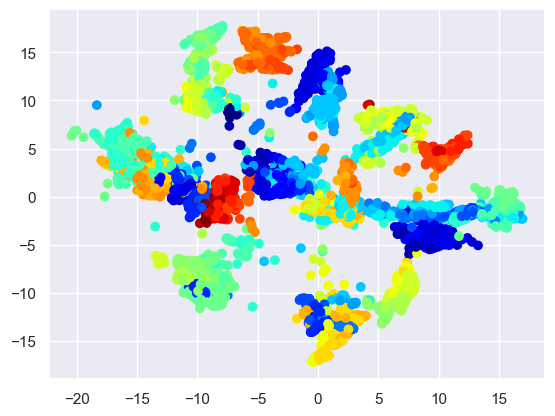

MENU DE CLUSTER
	1 - K-means
	2 - DBSCAN
	3 - Espectral
	9 - Salir

K-means


c:\Users\ovspa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


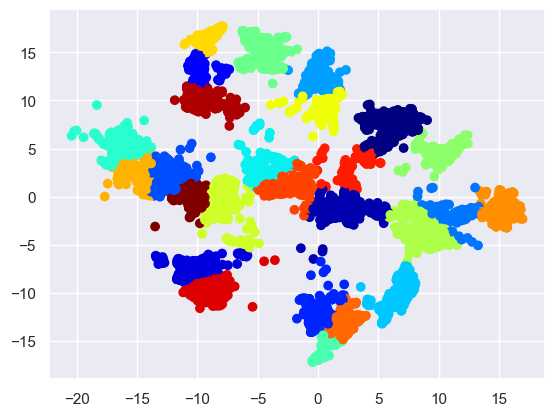


No has pulsado ninguna opción RD correcta...
Nclu: 26
hom: 0.340
Com: 1.000
vme: 0.508
ard: 0.000
ami: 0.000


c:\Users\ovspa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
c:\Users\ovspa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
c:\Users\ovspa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
c:\Users\ovspa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects d

In [33]:
# Ejecución Modelo Basado en DR (1 PARA DISCRIMINANTE Y 2 PARA TOPOLOGICO)

bz = fl
dEnc = 4

topoOdis = input("1 Discriminante, 2 Topologico")
# topoOdis = "2" # "1" discriminante,  "2" topologico

if topoOdis == "1":  # Es mejor reducir a 100 (no dcompatible con t-sne)
    # topologico con 5 iteraciones y selección 2 (directa)
    nepocas = 100
    combinacion, decodeComb = ensambleRNRD(listaMetodos, bz, nepocas, dEnc)
    combinacionL = np.column_stack((combinacion, labelsIn))
    graficar(combinacionL, False)
    clusteres(combinacionL)
    guardarRdRnx("NetDRdUmapD"+nombreDB, combinacionL)
    
elif topoOdis == "2":  # Es mejor reducir a 2 e incluir a t-sne
    # discriminante con 10 iteraciones y selección 1 (escalonada)
    nepocas = 100
    mejora, decodeComb = ensambleRNRT(listaMetodos, bz, nepocas, dEnc)
    #mejora = TRIMAP(n_dims=2).fit_transform(mejora)
    #mejora = umap(mejora, 2, device)
    mejora = np.column_stack((mejora, labelsIn))
    graficar(mejora, False)
    clusteres(mejora)
    guardarRdRnx("NetDRdUmapT"+nombreDB, mejora)
    

In [ ]:
graficar(combinacionL, False)
clusteres(combinacionL)

In [ ]:
#_________________________________________________________________

In [ ]:
graficar(combinacionL, False)
clusteres(combinacionL)

In [ ]:
matl = loadFile("NetDRdUmapD1v918FashionMnist")  # archivos .dat

# matl = loadFileMatlab("deepMklFashion", 'pr') # archivos .mat de MATLAB
graficar(matl, False)
clusteres(matl)

In [ ]:
# TRIMAP EN OTRAS DIMENSIONES
from trimap.trimap_ import TRIMAP
import numpy as np

embedding = TRIMAP(n_dims=2).fit_transform(Xin)
embedding = np.column_stack((embedding, labelsIn))
graficar(embedding, False)
#guardarRdRnx("Trimap2D"+nombreDB, embedding)
clusteres(embedding)

In [ ]:
from OtrosDR import umap, parametricumap, densemap, trimap, t_sne
dCmb = 2
tsnepba = t_sne(Xin, dCmb, device)
tsnepba = np.column_stack((tsnepba, labelsIn))
graficar(tsnepba, False)
clusteres(tsnepba)
guardarRdRnx("pruebaTsne"+nombreDB, tsnepba)